In [2]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit

In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(ro_amp=1, ef_ssm=-0.2568, qubit_thr=[-10000, -600], RO_LO=6.6247, qubit_id=q1, RO_LO_pwr=16, ROIF=0.10275000000000034, ef_amp=1.5, ef_time=49.13671850689116, ge_time=81.17534608287957, RO_IF=None, IQ_angle=205, ge_amp=0.8, ro_freq=6.72745, ge_ssm=-0.1145, ro_dur=4000)
Qubit(ro_amp=1.5, ef_ssm=-0.2962, qubit_thr=[-10000, 1900], RO_LO=6.6247, qubit_id=q2, RO_LO_pwr=16, ROIF=0.030899999999999928, ef_amp=1, ef_time=None, ge_time=45.047198597262124, RO_IF=None, IQ_angle=85, ge_amp=0.8, ro_freq=6.6556, ge_ssm=-0.154, ro_dur=4000)


In [4]:
def run_rabi_ef_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time = 20000
    swap_freq = -0.0195
    swap_time = 0.5 * 6 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value

        a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.5
        # if J is in units of rad/micros
        J_to_a = 1 / a_to_J
        ef_amp = J * J_to_a
        q1.ef_amp = ef_amp
        df_prob, df_pop, values = run_rabi_ef_swap(
            q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [17]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.5
# if J is in units of rad/micros
J_to_a = 1 / a_to_J
0.5 * J_to_a

0.023461054913060227

In [5]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / 1.2
# if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [18]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values

        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma = np.sqrt(abs(0.25**2 - J**2))
        guess_freq = np.sqrt(abs(0.25**2 - J**2)) / np.pi
        # Select initial guess values based on J
        if J <= 0.1:
            P_f_norm = P_f  # / norm_factor
            # P_f_norm = P_f
            guess_vals = [0.0000001, 0.0477, 0.1, -10, 0.5]
        else:
            P_f_norm = P_f  # / norm_factor
            guess_vals = [guess_freq, 0.2, 0.1, -10, 0.5]
        guess_vals = [guess_freq, guess_gamma, 0.1, -10, 0.5]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_decay(
            times, P_f_norm, guess_vals=guess_vals
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

In [7]:
def fit_func(J, J0):
    """
    Model function: Re(sqrt(2*(J^2 - J0^2))).
    Returns sqrt(2*(J^2 - J0^2)) if the argument is non-negative;
    otherwise returns 0.

    Parameters:
        J : array_like
            The independent variable.
        J0 : float
            The parameter to fit.

    Returns:
        array_like : The computed model values.
    """
    expr = 2 * (J**2 - J0**2)
    return np.where(expr >= 0, np.sqrt(expr), 0.0)


def curve_fit_function(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(sqrt(2*(J^2 - J0^2)))
    using the provided initial guess for J0.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            Optimal value for J0.
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])
    return popt, pcov


def curve_fit_and_plot(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function (without offset) and plots the original data
    (scatter plot) along with the fitted curve.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            The optimal parameter (J0) from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameter.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_J0)
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)

    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_J0)

    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30)
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.xlabel("J")
    plt.ylabel("Re(sqrt(2*(J^2 - J0^2)))")
    plt.title("Curve Fit: Data and Fitted Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt, pcov

In [8]:
def run_rabi_ef_no_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    ef_amp: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_no_swap.rabi_ef_no_swap(
        q1,
        q2,
        general_vals_dict,
        ef_amp,
        num_steps,
        sweep_time,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values


def run_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    swap_freq: float,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    return values

In [9]:
J_start = 0
J_stop = 1
J_steps = 201
# J_list = np.linspace(10, 10,1)#
J_list = np.linspace(J_start, J_stop, J_steps)
J_dict, vals_dict = sweep_J(J_list)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 88.679480 sec
Captured 200 buffers (2.255313 buffers per sec)
Captured 614400 records (6928.322119 records per sec)
Transferred 10066329600 bytes (113513629.596374 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, N

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

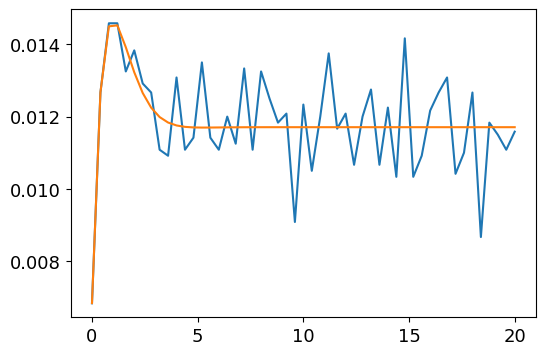



  freq: 0.11667652599064914 +/- 0.15110601146012337
 gamma: 1.3166897839020166 +/- 0.5139562741596962
   amp: 0.022325385806663513 +/- 0.03316031188369051
 phase: -12.59664405928228 +/- 18.728718065838837
offset: 0.011707153427329246 +/- 0.00018004223307884116
pi_pulse time: 4.285352137070586 +/- 0.15110601146012337
J = 0.0: Angular freq (rad/µs): 0.7331002337972038


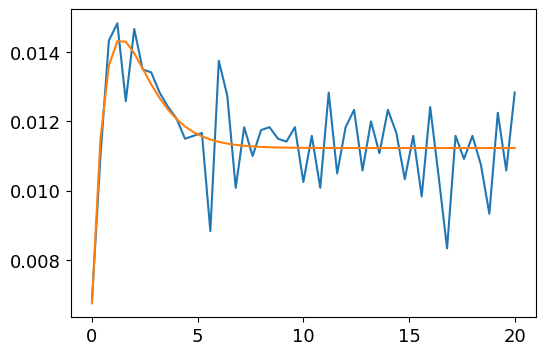



  freq: 0.001655435326390864 +/- 4.536552357521898
 gamma: 0.9920410834390416 +/- 0.31852025242356635
   amp: 1.171683476049259 +/- 3181.5764548455004
 phase: -0.21917942887086814 +/- 600.6745623279159
offset: 0.0112313177287548 +/- 0.0001944456662256823
pi_pulse time: 302.03535712270116 +/- 4.536552357521898
J = 0.005: Angular freq (rad/µs): 0.01040140691976512


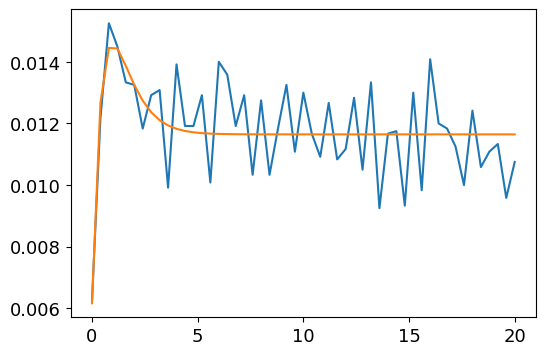



  freq: 0.001711823841252798 +/- 14.061728642365473
 gamma: 1.484390244793863 +/- 0.6483533854204436
   amp: 1.70611575486282 +/- 13880.9603552746
 phase: -0.18407634371738574 +/- 1512.1301975993824
offset: 0.011645874058404856 +/- 0.00021171036278744369
pi_pulse time: 292.0861293963958 +/- 14.061728642365473
J = 0.01: Angular freq (rad/µs): 0.0107557064078393


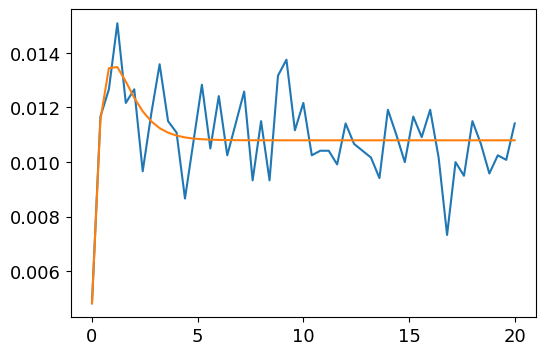



  freq: 0.0022890677249511565 +/- 10.741462753308088
 gamma: 1.4919765277927635 +/- 0.6352837996685353
   amp: 1.276504597988042 +/- 5932.5820041990355
 phase: -0.26782564474819825 +/- 1256.8283142777975
offset: 0.010799208980858609 +/- 0.0002123607789005735
pi_pulse time: 218.42953554843768 +/- 10.741462753308088
J = 0.015: Angular freq (rad/µs): 0.014382636696552108


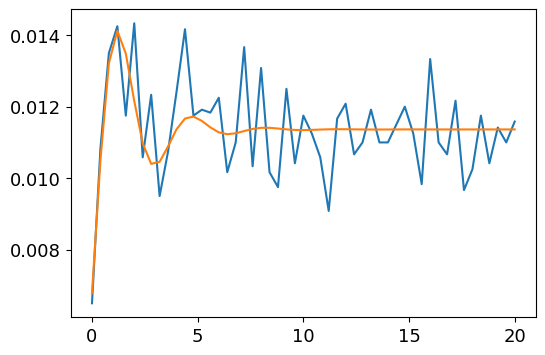



  freq: 0.28647310856186764 +/- 0.036639915927729576
 gamma: 0.5774758036794596 +/- 0.21507990007694797
   amp: 0.005805541489931974 +/- 0.0016481193545848196
 phase: -52.06417889831475 +/- 15.301033069047541
offset: 0.011363408440652542 +/- 0.00016475416006777254
pi_pulse time: 1.7453645213334865 +/- 0.036639915927729576
J = 0.02: Angular freq (rad/µs): 1.7999636266179893


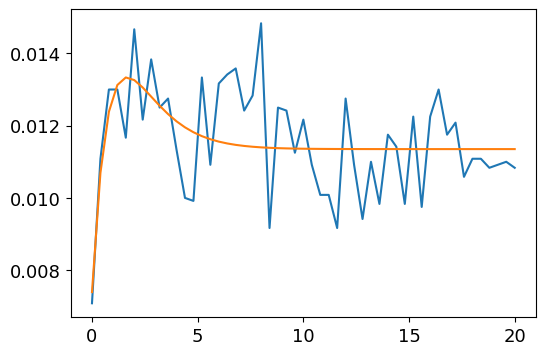



  freq: 0.0005145578580812905 +/- 19.581097127541643
 gamma: 0.8829921717262491 +/- 0.43880312919036885
   amp: 2.339486050376866 +/- 88093.9390744425
 phase: -0.09693088292962802 +/- 3688.6519136744223
offset: 0.011350628414998168 +/- 0.0002489810224616068
pi_pulse time: 971.7080249525785 +/- 19.581097127541643
J = 0.025: Angular freq (rad/µs): 0.0032330623735901632
RuntimeError


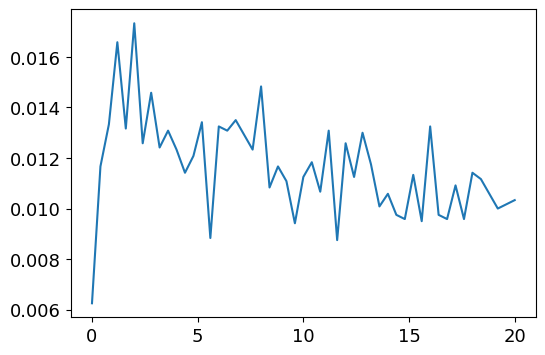



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.03: Angular freq (rad/µs): nan


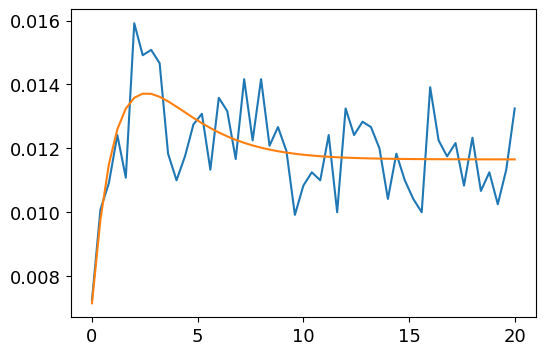



  freq: 0.0007716462539825845 +/- 4.579548187376885
 gamma: 0.5804205586352885 +/- 0.21403329830061268
   amp: 1.100064740058602 +/- 6461.143259643668
 phase: -0.23461820786037513 +/- 1392.452402285629
offset: 0.01165381574577907 +/- 0.0003048486842106124
pi_pulse time: 647.9653045931649 +/- 4.579548187376885
J = 0.035: Angular freq (rad/µs): 0.004848396405363542


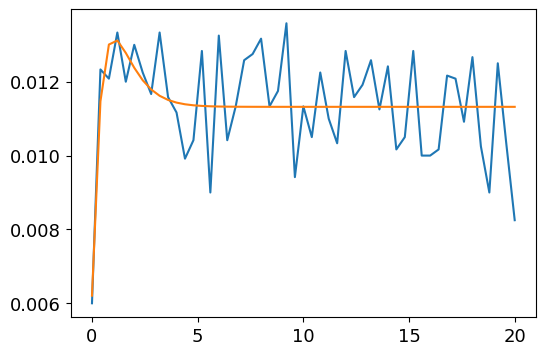



  freq: 0.0014082360389249852 +/- 24.780925261821984
 gamma: 1.5133356795908244 +/- 0.8193568805956685
   amp: 1.5222659841218553 +/- 26504.688877563574
 phase: -0.19246504491376398 +/- 3386.8796822681097
offset: 0.011320228407521483 +/- 0.00021002554242781203
pi_pulse time: 355.05411463669714 +/- 24.780925261821984
J = 0.04: Angular freq (rad/µs): 0.008848207988814246


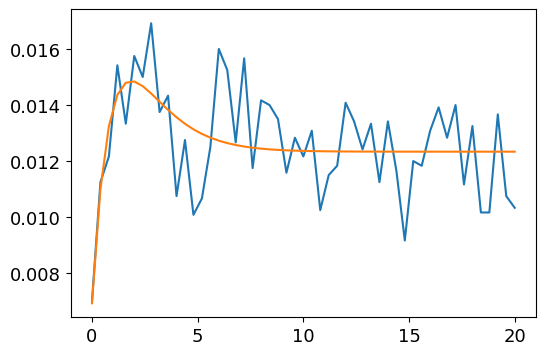



  freq: 0.0009132674317535574 +/- 8.33626907162486
 gamma: 0.8014731709003485 +/- 0.3548698317091646
   amp: 1.5549208269424417 +/- 14045.002302812682
 phase: -0.19929804671217918 +/- 1819.226245957587
offset: 0.012335765019752025 +/- 0.0003189170486704915
pi_pulse time: 547.484759245114 +/- 8.33626907162486
J = 0.045: Angular freq (rad/µs): 0.005738228508719588


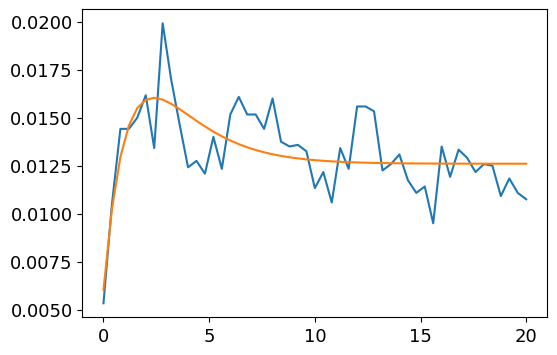



  freq: 0.0002687189653831659 +/- 12.366422998302872
 gamma: 0.6093724065111356 +/- 0.20186582375877132
   amp: 5.2786257793949565 +/- 240785.5152214147
 phase: -0.07126161270500507 +/- 3279.4655138263715
offset: 0.012600918142210257 +/- 0.0003970211474577922
pi_pulse time: 1860.6799832198328 +/- 12.366422998302872
J = 0.05: Angular freq (rad/µs): 0.0016884110550560078


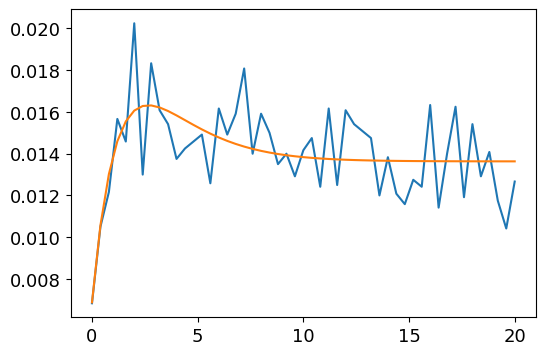



  freq: 0.0003238831793968478 +/- 11.35619215461577
 gamma: 0.5776362523344105 +/- 0.21308628413690806
   amp: 3.557009695662238 +/- 123556.0772000775
 phase: -0.10880775431164133 +/- 3815.105327957035
offset: 0.013632418219189242 +/- 0.0004381277078148025
pi_pulse time: 1543.7664930025885 +/- 11.35619215461577
J = 0.055: Angular freq (rad/µs): 0.0020350180340288843
RuntimeError


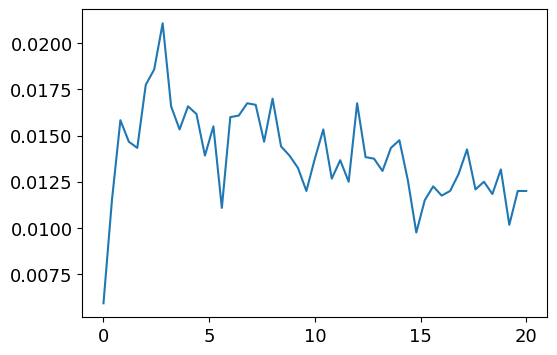



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.06: Angular freq (rad/µs): nan
RuntimeError


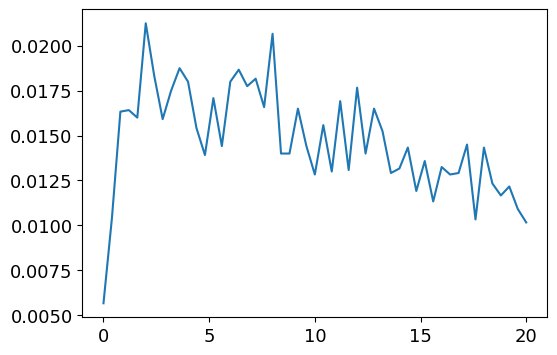



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.065: Angular freq (rad/µs): nan
RuntimeError


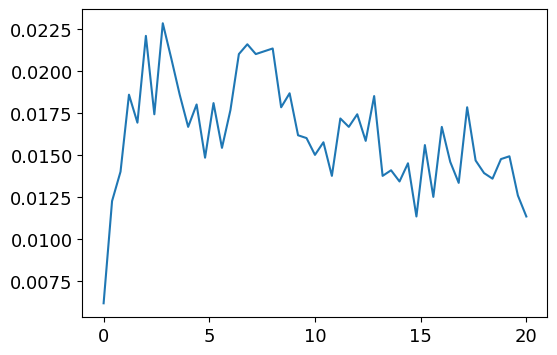



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.07: Angular freq (rad/µs): nan
RuntimeError


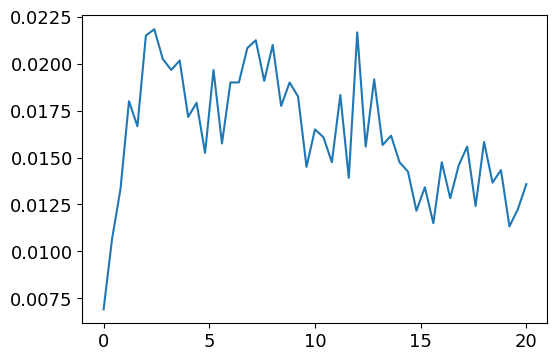



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.075: Angular freq (rad/µs): nan
RuntimeError


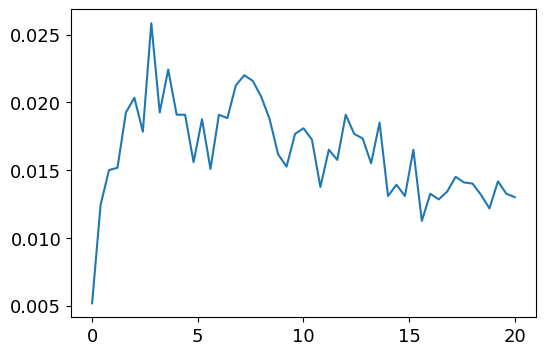



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.08: Angular freq (rad/µs): nan
RuntimeError


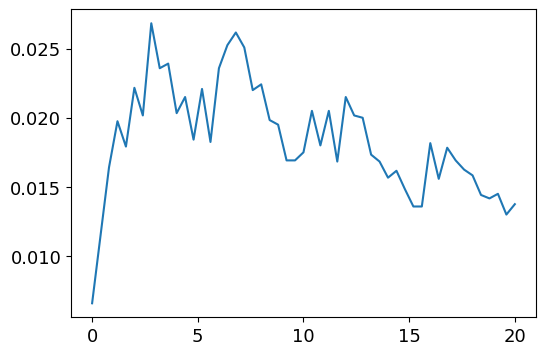



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.085: Angular freq (rad/µs): nan
RuntimeError


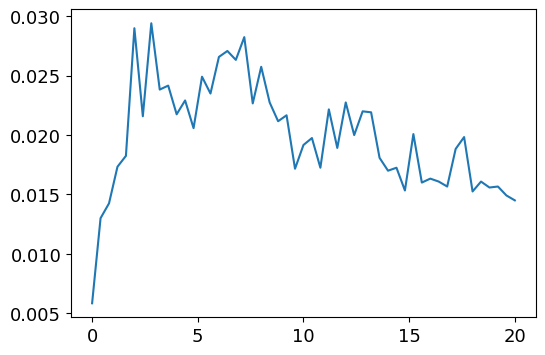



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.09: Angular freq (rad/µs): nan
RuntimeError


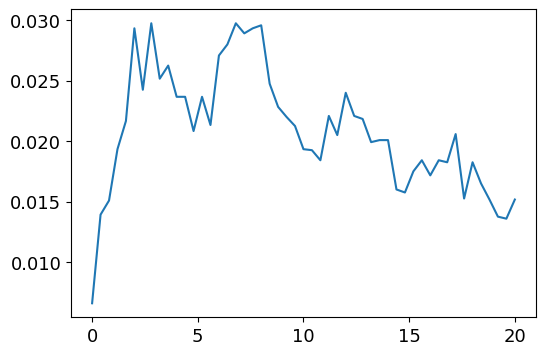



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.095: Angular freq (rad/µs): nan
RuntimeError


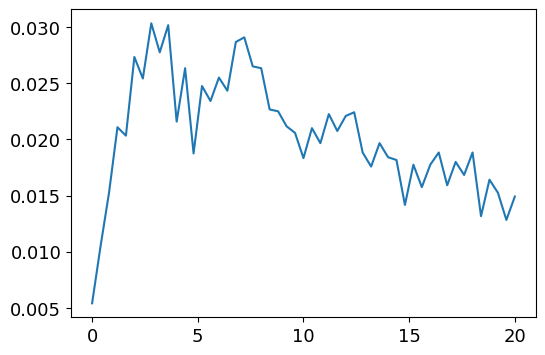



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.1: Angular freq (rad/µs): nan
RuntimeError


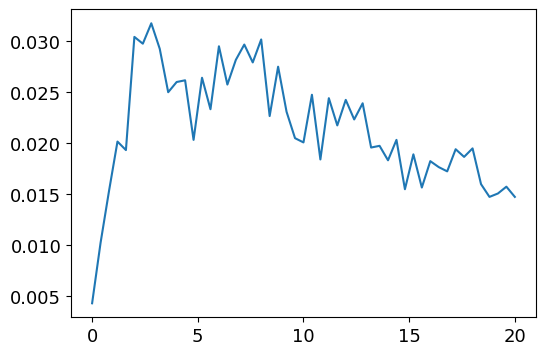



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.105: Angular freq (rad/µs): nan
RuntimeError


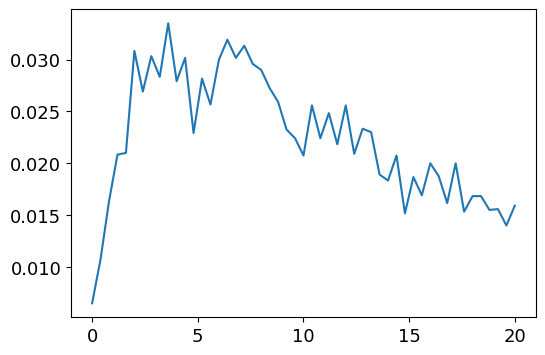



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.11: Angular freq (rad/µs): nan
RuntimeError


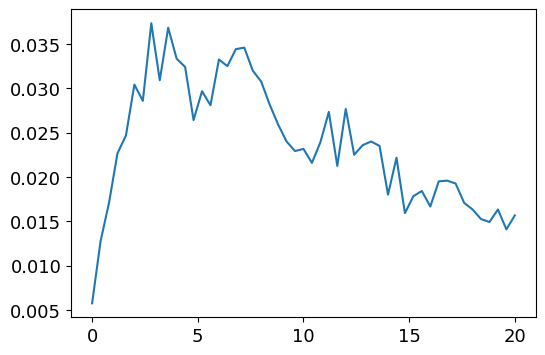



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.115: Angular freq (rad/µs): nan
RuntimeError


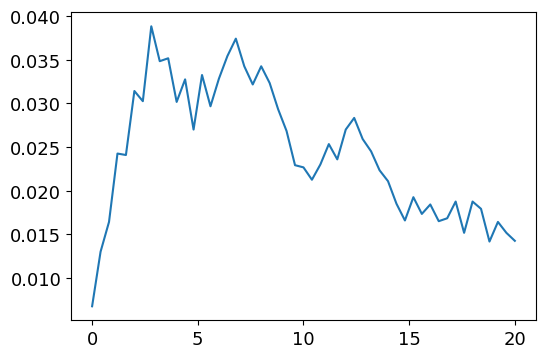



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.12: Angular freq (rad/µs): nan
RuntimeError


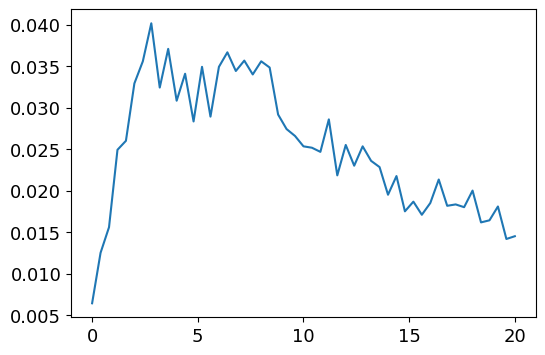



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.125: Angular freq (rad/µs): nan
RuntimeError


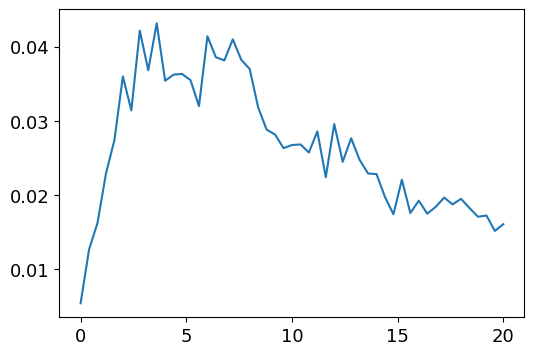



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.13: Angular freq (rad/µs): nan
RuntimeError


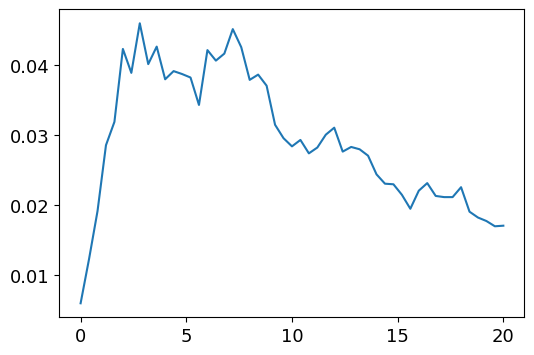



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.135: Angular freq (rad/µs): nan
RuntimeError


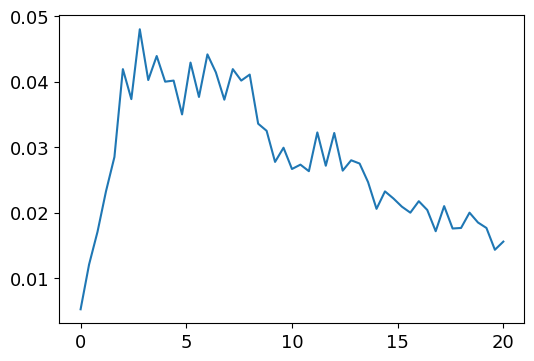



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.14: Angular freq (rad/µs): nan
RuntimeError


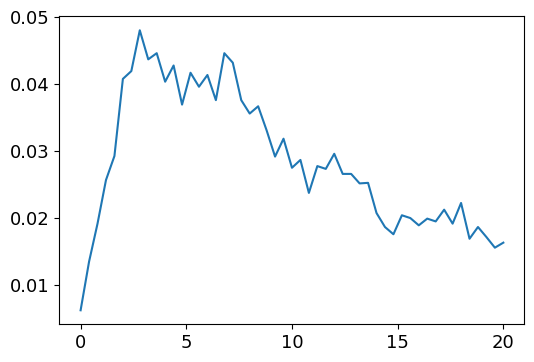



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.145: Angular freq (rad/µs): nan


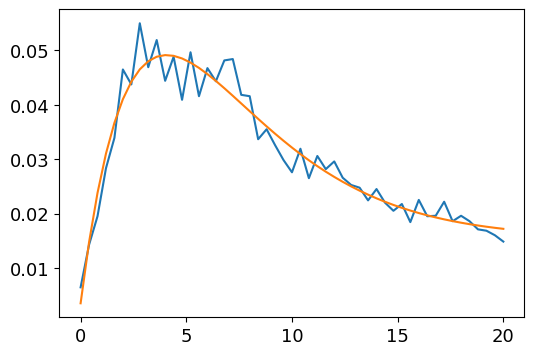



  freq: 0.01285095579786212 +/- 0.021782728156573623
 gamma: 0.26751325430730966 +/- 0.031167314977958344
   amp: 0.34491473205502227 +/- 0.6227962308726332
 phase: -2.0040036304086724 +/- 3.950978744097213
offset: 0.015544080263081609 +/- 0.0031830509798328518
pi_pulse time: 38.90761184340699 +/- 0.021782728156573623
J = 0.15: Angular freq (rad/µs): 0.0807449366523416


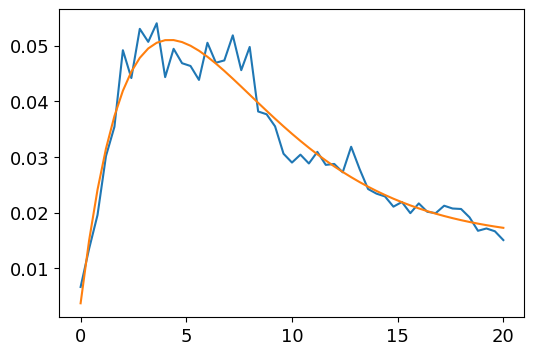



  freq: 0.012671794602384408 +/- 0.02158766118297512
 gamma: 0.25487299952339315 +/- 0.03051150534850122
   amp: 0.35200657024921705 +/- 0.6420225507576639
 phase: -1.854462954691014 +/- 3.8043348558486128
offset: 0.015130474233426438 +/- 0.0038648842246861393
pi_pulse time: 39.457710268276976 +/- 0.02158766118297512
J = 0.155: Angular freq (rad/µs): 0.0796192336612993


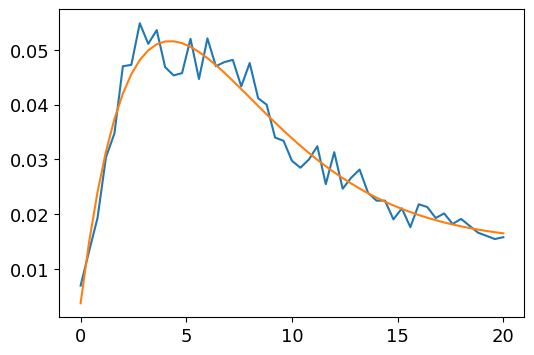



  freq: 0.017968070409537726 +/- 0.012749446044289747
 gamma: 0.24471864105931196 +/- 0.026546785781957686
   amp: 0.24581305510542964 +/- 0.20044113240890038
 phase: -2.6295576100367986 +/- 2.670192233510014
offset: 0.015064637153811199 +/- 0.0032846532100591227
pi_pulse time: 27.82713939803978 +/- 0.012749446044289747
J = 0.16: Angular freq (rad/µs): 0.11289671599557573
RuntimeError


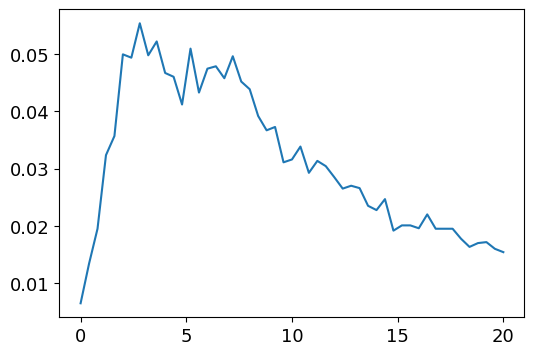



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.165: Angular freq (rad/µs): nan


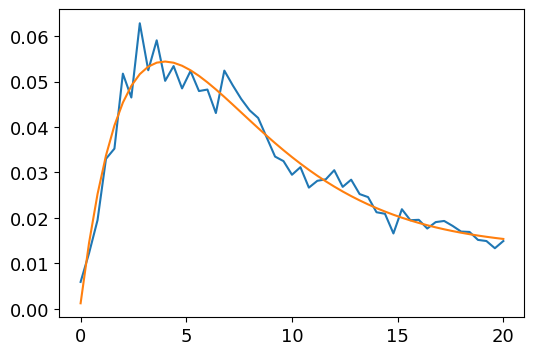



  freq: 0.011567947497860536 +/- 0.02236401313852966
 gamma: 0.2697373560543865 +/- 0.029302922138047357
   amp: 0.46248022127340455 +/- 0.9427292944915304
 phase: -1.4964333276317898 +/- 3.3213427191369487
offset: 0.01329679604942068 +/- 0.003515475210015866
pi_pulse time: 43.22287943409786 +/- 0.02236401313852966
J = 0.17: Angular freq (rad/µs): 0.07268355775278218


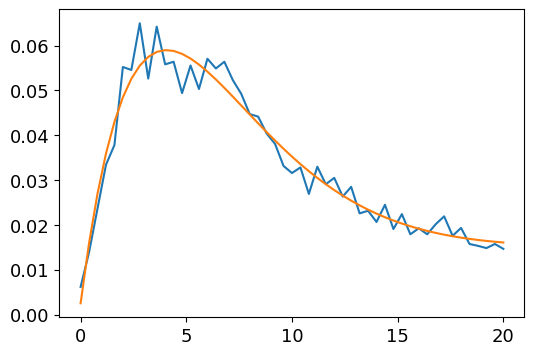



  freq: 0.022601401449324706 +/- 0.009233357892217233
 gamma: 0.24658652544568857 +/- 0.02558541650656851
   amp: 0.2375894710590851 +/- 0.11984147428412423
 phase: -3.1295069251228256 +/- 2.0635684188921632
offset: 0.015490556422854719 +/- 0.003042395057819568
pi_pulse time: 22.122521964890776 +/- 0.009233357892217233
J = 0.17500000000000002: Angular freq (rad/µs): 0.1420087935080644


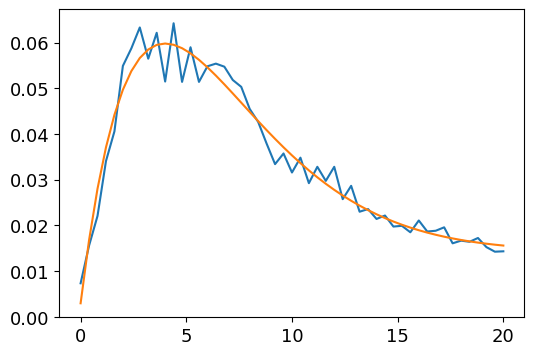



  freq: 0.02037460127433377 +/- 0.009913115603355133
 gamma: 0.2525276490421792 +/- 0.024639465356172664
   amp: 0.2744957620067826 +/- 0.15857993223882877
 phase: -2.424325869753442 +/- 1.824568962957231
offset: 0.014568922301420997 +/- 0.0030205452502044374
pi_pulse time: 24.540357539652 +/- 0.009913115603355133
J = 0.18: Angular freq (rad/µs): 0.12801739536653642


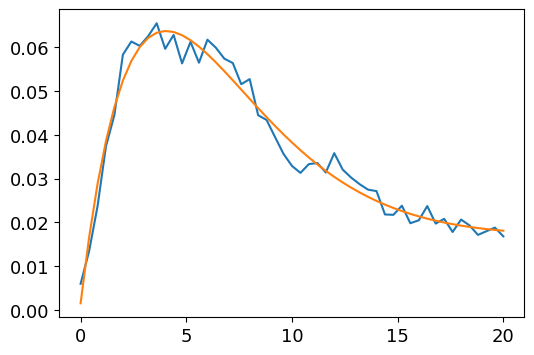



  freq: 0.02148678888035239 +/- 0.008041397053801002
 gamma: 0.25382806117388884 +/- 0.020650902911835484
   amp: 0.276052053022485 +/- 0.12409385093924466
 phase: -3.270428275991265 +/- 1.8074516534449132
offset: 0.017295885110239207 +/- 0.0025834872250884815
pi_pulse time: 23.270112755526817 +/- 0.008041397053801002
J = 0.185: Angular freq (rad/µs): 0.13500547619149986


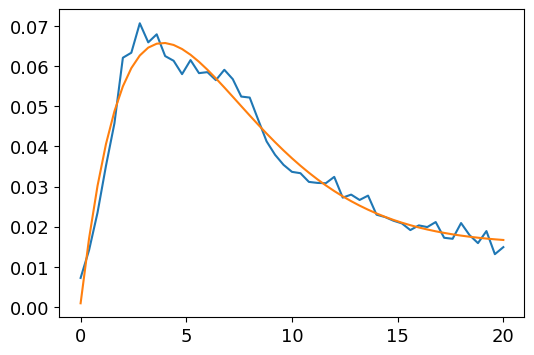



  freq: 0.021768963749646156 +/- 0.008371919756420255
 gamma: 0.2615721385806251 +/- 0.022208832260687664
   amp: 0.2973967955416517 +/- 0.13739860039322818
 phase: -2.903274888994742 +/- 1.6555201409494207
offset: 0.01600108235814805 +/- 0.0026365192495160054
pi_pulse time: 22.968479609330384 +/- 0.008371919756420255
J = 0.19: Angular freq (rad/µs): 0.13677843318430177


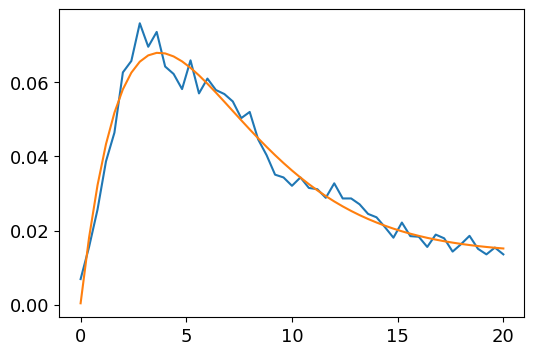



  freq: 0.017965520586848596 +/- 0.011350325113001275
 gamma: 0.27785269265078055 +/- 0.02454716644316608
   amp: 0.403190359641179 +/- 0.2875696999494075
 phase: -1.9252349323445073 +/- 1.6169387815121203
offset: 0.013936796333613562 +/- 0.0028870720979128728
pi_pulse time: 27.83108886730607 +/- 0.011350325113001275
J = 0.195: Angular freq (rad/µs): 0.11288069498711947


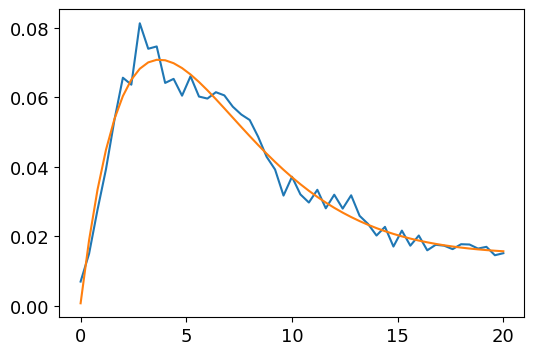



  freq: 0.021827173971856642 +/- 0.009198044653385815
 gamma: 0.27063786973049037 +/- 0.024923839956426795
   amp: 0.33856940301204685 +/- 0.17076880732127903
 phase: -2.4246439366478536 +/- 1.527504853645122
offset: 0.015079485267542225 +/- 0.0029132503305219653
pi_pulse time: 22.907225674046774 +/- 0.009198044653385815
J = 0.2: Angular freq (rad/µs): 0.13714417879722235


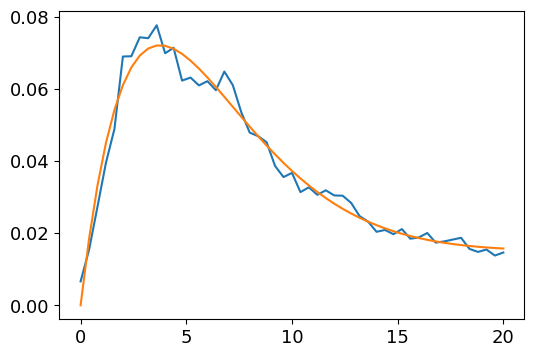



  freq: 0.023711505113534394 +/- 0.006981994763326364
 gamma: 0.2660297266701907 +/- 0.02081973823519944
   amp: 0.31493088290950144 +/- 0.11474327966569736
 phase: -2.8059085924446476 +/- 1.2987785496242152
offset: 0.01537645544353923 +/- 0.002451993835770835
pi_pulse time: 21.086809867442906 +/- 0.006981994763326364
J = 0.20500000000000002: Angular freq (rad/µs): 0.14898378054047293


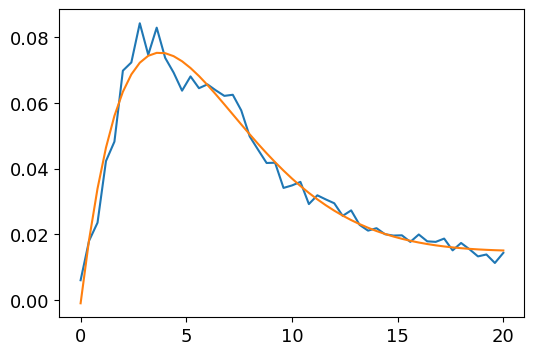



  freq: 0.02712255930231289 +/- 0.0062798689444088715
 gamma: 0.2587597955753531 +/- 0.02224360676315539
   amp: 0.2873335277441231 +/- 0.08818659910864739
 phase: -3.272300955809912 +/- 1.3363487598903352
offset: 0.01547348309903153 +/- 0.0026192977331775127
pi_pulse time: 18.434838483599968 +/- 0.0062798689444088715
J = 0.21: Angular freq (rad/µs): 0.17041606610139937


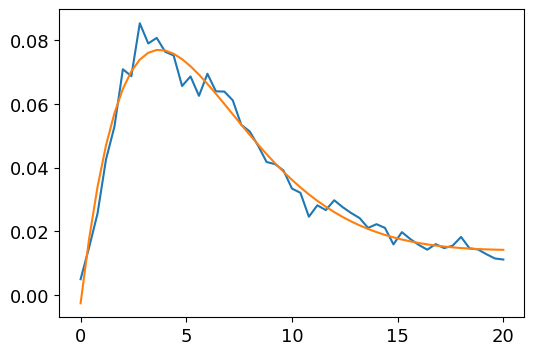



  freq: 0.02841004010931434 +/- 0.005254794105912315
 gamma: 0.258451160173707 +/- 0.019759471014402667
   amp: 0.2863874788222565 +/- 0.0719650383512873
 phase: -3.4731184485645534 +/- 1.1659207294704277
offset: 0.014796780622525681 +/- 0.0023094553458137927
pi_pulse time: 17.599411971124713 +/- 0.005254794105912315
J = 0.215: Angular freq (rad/µs): 0.17850554659122658


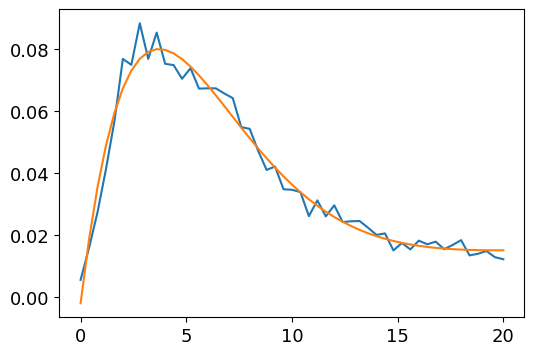



  freq: 0.031199502095554527 +/- 0.004534121457394502
 gamma: 0.2533863157013912 +/- 0.01939012192600861
   amp: 0.26700892392616177 +/- 0.05619531427567615
 phase: -3.9092332875251854 +/- 1.1268496702386244
offset: 0.016234147261860076 +/- 0.002186810721923491
pi_pulse time: 16.02589677452714 +/- 0.004534121457394502
J = 0.22: Angular freq (rad/µs): 0.1960322531581069


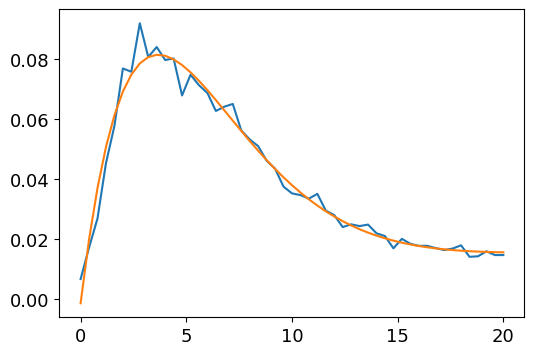



  freq: 0.028420385878170466 +/- 0.005039066266638439
 gamma: 0.2622190650416279 +/- 0.019002537716794443
   amp: 0.30404503547997624 +/- 0.07299002979536783
 phase: -3.3152593873876235 +/- 1.0653377570761158
offset: 0.016245645025749936 +/- 0.002240586239216505
pi_pulse time: 17.59300532172039 +/- 0.005039066266638439
J = 0.225: Angular freq (rad/µs): 0.17857055097409488


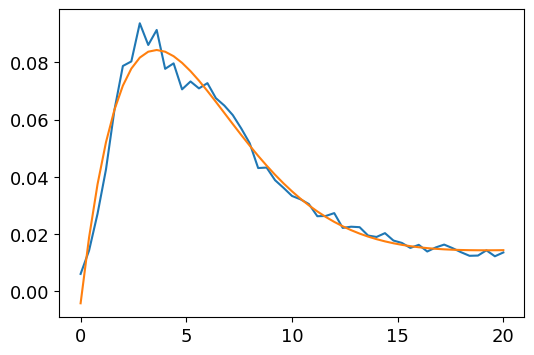



  freq: 0.032169005093885254 +/- 0.004313586632381649
 gamma: 0.26236487824887433 +/- 0.019119519923563914
   amp: 0.28886304663043444 +/- 0.0564886965297895
 phase: -3.9072687212864325 +/- 1.0279723161367316
offset: 0.015511317445948457 +/- 0.0020730817517753686
pi_pulse time: 15.542911524330634 +/- 0.004313586632381649
J = 0.23: Angular freq (rad/µs): 0.2021238201524851


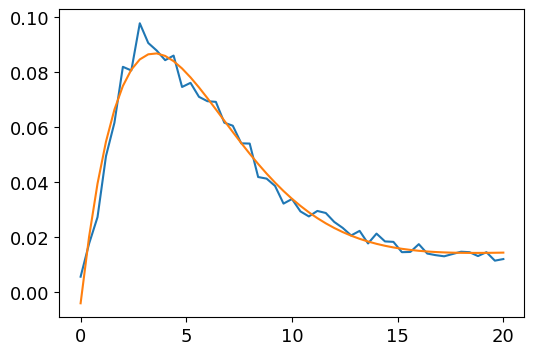



  freq: -0.03305714488578603 +/- 0.0039359279684440425
 gamma: 0.2677689059582351 +/- 0.018118783845917828
   amp: 0.29672887651716606 +/- 0.052150965498040706
 phase: 183.7794619839672 +/- 0.9051518403837907
offset: 0.015391996071364274 +/- 0.0018743821845894101
pi_pulse time: -15.125323185880788 +/- 0.0039359279684440425
J = 0.23500000000000001: Angular freq (rad/µs): 0.20770416704367758


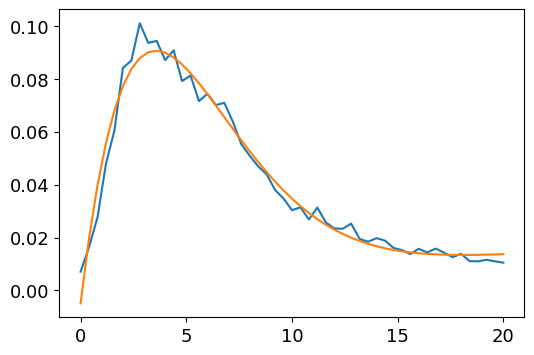



  freq: -0.034432189562682264 +/- 0.003732614341998054
 gamma: 0.2560369481936364 +/- 0.018467688222354454
   amp: 0.29081532431643764 +/- 0.04901513759254287
 phase: 183.9652384589915 +/- 0.9604367507411189
offset: 0.015252875391431824 +/- 0.0020932325322326997
pi_pulse time: -14.521295518827587 +/- 0.003732614341998054
J = 0.24: Angular freq (rad/µs): 0.2163438275542675


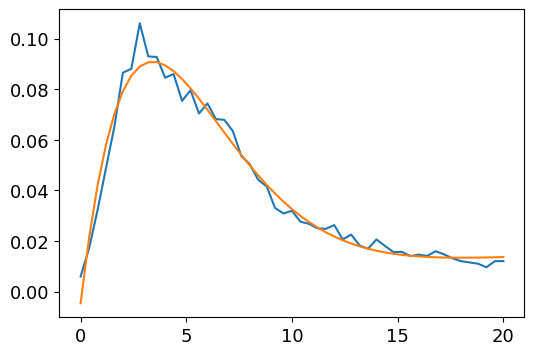



  freq: 0.03427454752672497 +/- 0.004142035653189933
 gamma: 0.27129636796628004 +/- 0.02011652499691593
   amp: -0.308197741968066 +/- 0.05628194959334586
 phase: -183.62187867430512 +/- 0.9345008851896773
offset: 0.014901309412435728 +/- 0.0020455223016440254
pi_pulse time: 14.588084630734624 +/- 0.004142035653189933
J = 0.245: Angular freq (rad/µs): 0.21535333343014676


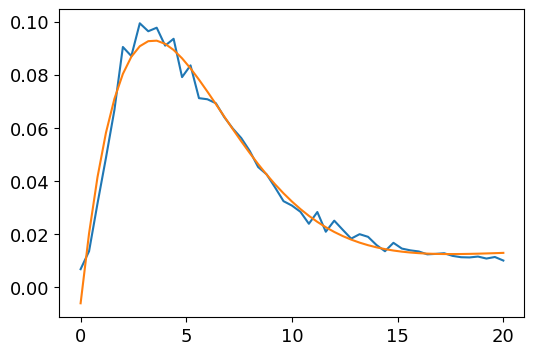



  freq: -0.035542686669123136 +/- 0.003321978225086258
 gamma: 0.26404817088180543 +/- 0.017099422246814166
   amp: -0.30190897637833886 +/- 0.044398801156551405
 phase: -356.1214475699061 +/- 0.8256178388238168
offset: 0.014428735431935909 +/- 0.001815407052736325
pi_pulse time: -14.067591587958463 +/- 0.003321978225086258
J = 0.25: Angular freq (rad/µs): 0.22332128665712223


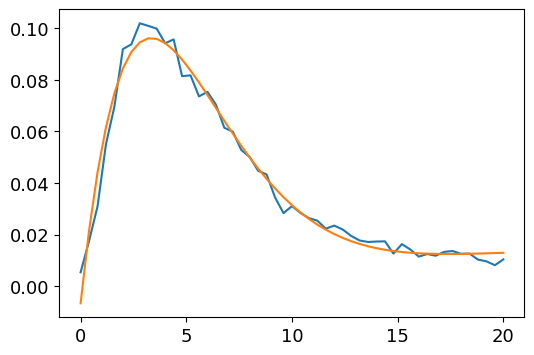



  freq: 0.035619880791518184 +/- 0.003254732088664741
 gamma: 0.27466530244306286 +/- 0.016621384066129757
   amp: -0.3248241360109942 +/- 0.04593289119227922
 phase: -183.67820402334777 +/- 0.7454222800796705
offset: 0.014249727514812894 +/- 0.0016970416536565818
pi_pulse time: 14.03710481027382 +/- 0.003254732088664741
J = 0.255: Angular freq (rad/µs): 0.2238063116327554


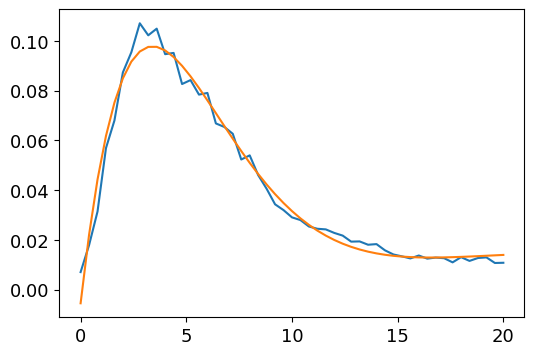



  freq: -0.03799698803738174 +/- 0.002801552296660508
 gamma: 0.2608019932568315 +/- 0.01597863604794319
   amp: 0.29577221355198663 +/- 0.03661083760657747
 phase: 184.07899092380322 +/- 0.7684683389516809
offset: 0.01559363782691414 +/- 0.0016635254881820084
pi_pulse time: -13.158937742857303 +/- 0.002801552296660508
J = 0.26: Angular freq (rad/µs): 0.23874211695355543


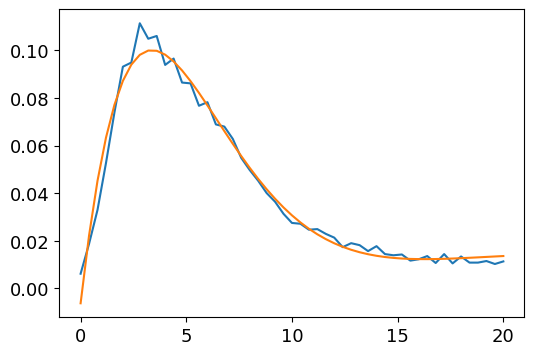



  freq: -0.038757130553894376 +/- 0.0026861712986356676
 gamma: 0.2612394501209721 +/- 0.015780880532208892
   amp: 0.30070164512313086 +/- 0.03562373745551909
 phase: 184.09381446011415 +/- 0.7519696900169975
offset: 0.015209694254180943 +/- 0.0016455574230655272
pi_pulse time: -12.900851865302997 +/- 0.0026861712986356676
J = 0.265: Angular freq (rad/µs): 0.24351823324467015


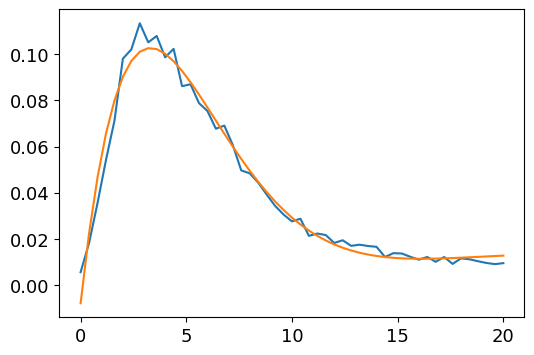



  freq: 0.03902158359266962 +/- 0.0028598484869884603
 gamma: 0.2682140774247685 +/- 0.016802494038309947
   amp: 0.3180950818831688 +/- 0.039518219650855314
 phase: -3.988312536452961 +/- 0.7662720084392296
offset: 0.01424153116620322 +/- 0.0017263367955974347
pi_pulse time: 12.813421546887893 +/- 0.0028598484869884603
J = 0.27: Angular freq (rad/µs): 0.24517984069234178


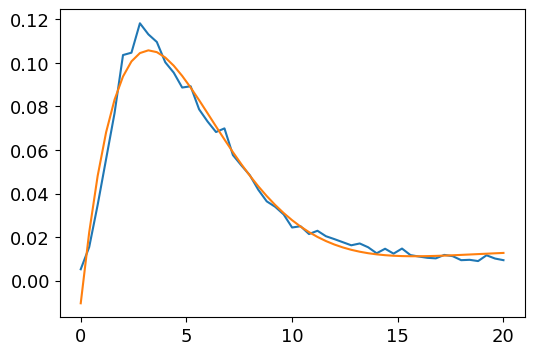



  freq: 0.039773482547318065 +/- 0.0030230731337748474
 gamma: 0.2772532029556715 +/- 0.017860901684377792
   amp: 0.33516910371093855 +/- 0.042937193919519605
 phase: -4.174092207073916 +/- 0.7925579589549818
offset: 0.014025729633725136 +/- 0.001770378805268007
pi_pulse time: 12.571189847536122 +/- 0.0030230731337748474
J = 0.275: Angular freq (rad/µs): 0.24990416115667258


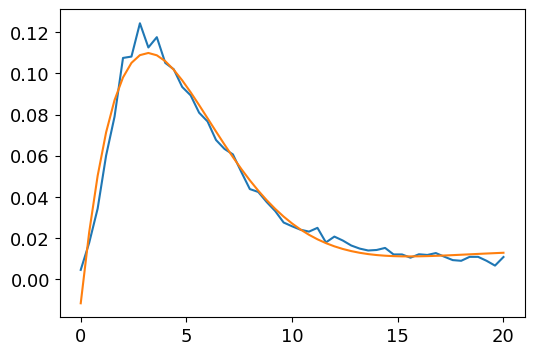



  freq: 0.040495456019918635 +/- 0.0030318248871892416
 gamma: 0.2815149392694252 +/- 0.018213691506735536
   amp: 0.3496069115820395 +/- 0.04439725027472016
 phase: -4.220134615350044 +/- 0.7932721679013862
offset: 0.014096798001157896 +/- 0.0018022375552566535
pi_pulse time: 12.347064316402891 +/- 0.0030318248871892416
J = 0.28: Angular freq (rad/µs): 0.2544404542718899


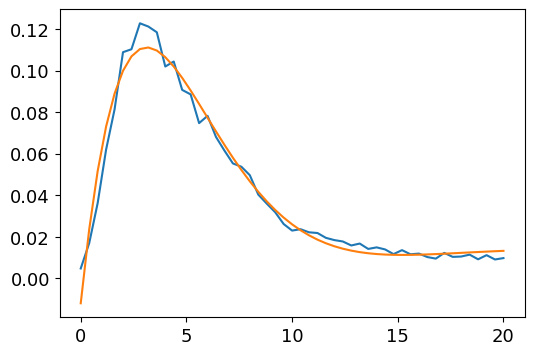



  freq: 0.041296561339041256 +/- 0.0030760553724093267
 gamma: 0.28660671644858937 +/- 0.018790820774800394
   amp: 0.3534428939224237 +/- 0.04491254460535203
 phase: -4.267244221960692 +/- 0.8013807658787584
offset: 0.014289705925475675 +/- 0.0017885808872439314
pi_pulse time: 12.107545611244543 +/- 0.0030760553724093267
J = 0.28500000000000003: Angular freq (rad/µs): 0.25947394744250457


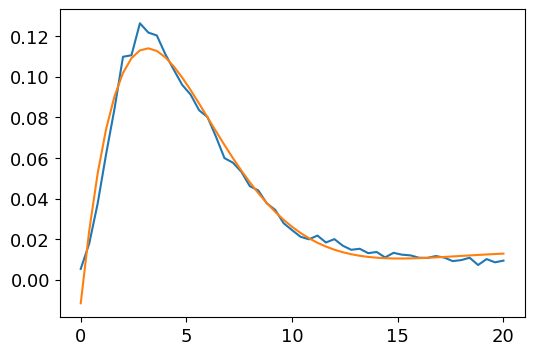



  freq: 0.041855438053603526 +/- 0.0026428718961946946
 gamma: 0.2779941318713804 +/- 0.01681014124969428
   amp: 0.3500755981911148 +/- 0.03906785561696892
 phase: -4.204192458250871 +/- 0.7378688972457662
offset: 0.014062774329329595 +/- 0.0016947545646973207
pi_pulse time: 11.945879036307272 +/- 0.0026428718961946946
J = 0.29: Angular freq (rad/µs): 0.262985473403967


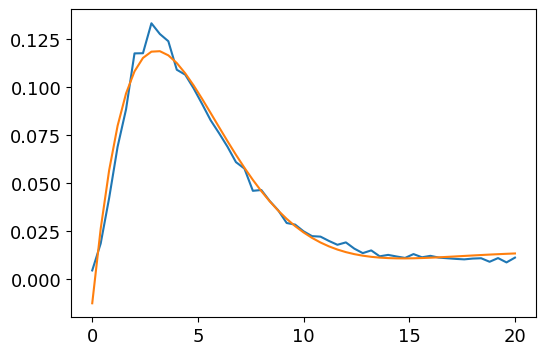



  freq: 0.04285067480545992 +/- 0.002688360819417117
 gamma: 0.29206507883582694 +/- 0.017189472390413983
   amp: 0.37405653160602376 +/- 0.0410283204257436
 phase: -4.110800486011459 +/- 0.7052993116909911
offset: 0.014303532675073184 +/- 0.0016336008291947105
pi_pulse time: 11.668427679843477 +/- 0.002688360819417117
J = 0.295: Angular freq (rad/µs): 0.26923873034039625


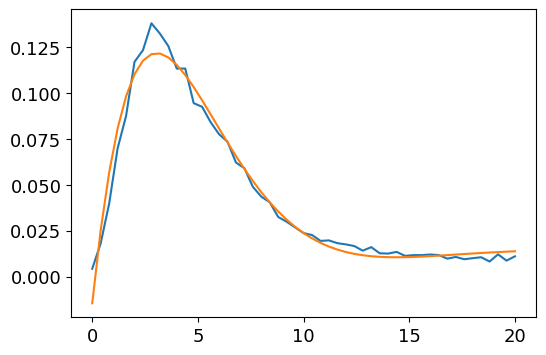



  freq: 0.04411543741689404 +/- 0.002739466073745508
 gamma: 0.28760870610911804 +/- 0.018247504997424658
   amp: 0.37094851436298304 +/- 0.041663094655282534
 phase: -4.5095997160729 +/- 0.785192161003053
offset: 0.014683905515152171 +/- 0.001776771136191005
pi_pulse time: 11.33390099422486 +/- 0.002739466073745508
J = 0.3: Angular freq (rad/µs): 0.2771854681976292


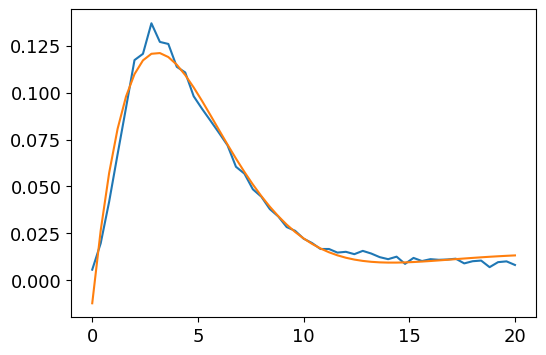



  freq: 0.044916242398434836 +/- 0.0023368960389629472
 gamma: 0.2811339637765793 +/- 0.016345580989231123
   amp: 0.3561454414637228 +/- 0.03488915361153381
 phase: -4.236187574277947 +/- 0.7143476839977118
offset: 0.01417647894718469 +/- 0.0015939061454973908
pi_pulse time: 11.131830565092487 +/- 0.0023368960389629472
J = 0.305: Angular freq (rad/µs): 0.28221707429156256


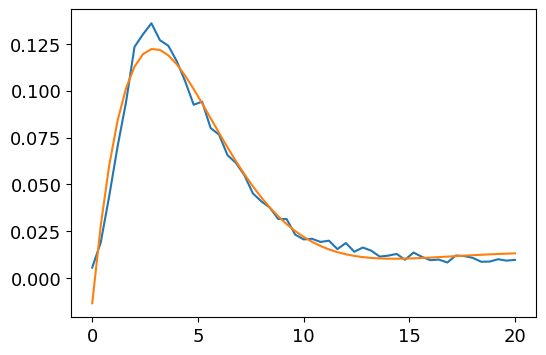



  freq: 0.044100020141057364 +/- 0.0029284089320346057
 gamma: 0.30179268748887167 +/- 0.019108371894604806
   amp: 0.3892291877799492 +/- 0.04540369656437209
 phase: -4.026787491350559 +/- 0.7499422119336385
offset: 0.01381836722936514 +/- 0.0017372081157659982
pi_pulse time: 11.337863302572446 +/- 0.0029284089320346057
J = 0.31: Angular freq (rad/µs): 0.27708859859661544


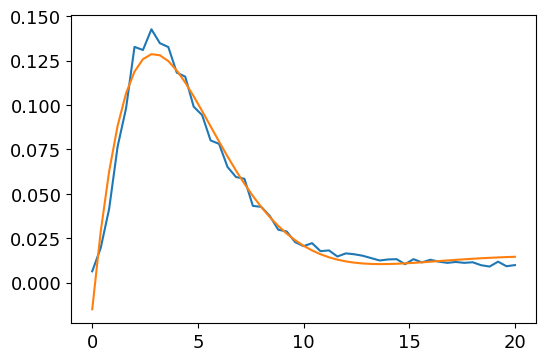



  freq: 0.04654651444088238 +/- 0.002757682705296733
 gamma: 0.2982779800911783 +/- 0.019324915006865936
   amp: 0.38771456711728797 +/- 0.042641890834137476
 phase: -4.444994267840793 +/- 0.7982830220392794
offset: 0.014995285621281156 +/- 0.0017886720205242527
pi_pulse time: 10.741942893168469 +/- 0.002757682705296733
J = 0.315: Angular freq (rad/µs): 0.29246037563537464


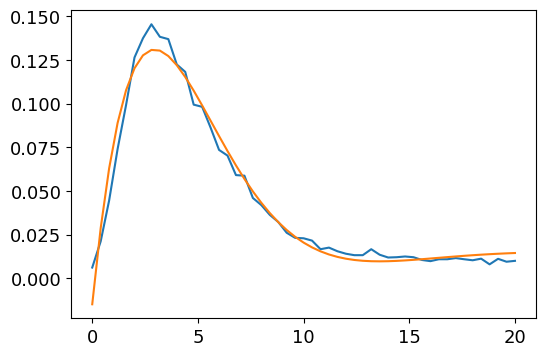



  freq: 0.047031809896213445 +/- 0.0025125889802120114
 gamma: 0.2909273973995595 +/- 0.018177604115294968
   amp: 0.383675836585071 +/- 0.03923229005403144
 phase: -4.460678703292077 +/- 0.7790472138018502
offset: 0.01506699195729825 +/- 0.0017547335650724052
pi_pulse time: 10.631102675048346 +/- 0.0025125889802120114
J = 0.32: Angular freq (rad/µs): 0.2955095769099518


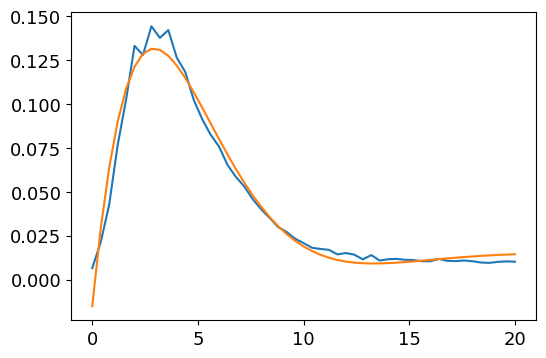



  freq: 0.04806683217516743 +/- 0.0024850134531507516
 gamma: 0.2916430584078546 +/- 0.01844683737293032
   amp: 0.38051938771012617 +/- 0.03838537821011535
 phase: -4.520655931511178 +/- 0.7968426465615942
offset: 0.014843780244927147 +/- 0.001750370996813892
pi_pulse time: 10.402183322126914 +/- 0.0024850134531507516
J = 0.325: Angular freq (rad/µs): 0.302012813685679


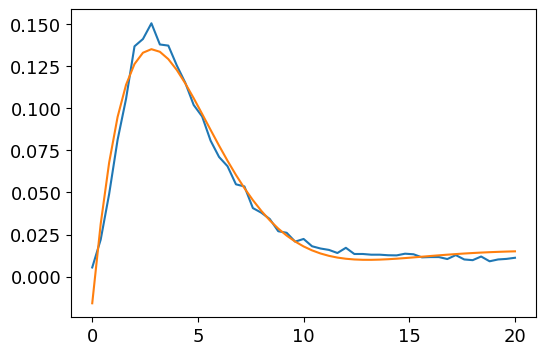



  freq: 0.04891451092853757 +/- 0.0025074189685915047
 gamma: 0.30610326768223023 +/- 0.01839243806952156
   amp: 0.40013468358238957 +/- 0.03914667930123936
 phase: -4.445810175774073 +/- 0.7466579500264862
offset: 0.015261399831101191 +/- 0.0016498892456178291
pi_pulse time: 10.221915552431525 +/- 0.0025074189685915047
J = 0.33: Angular freq (rad/µs): 0.30733893637406257


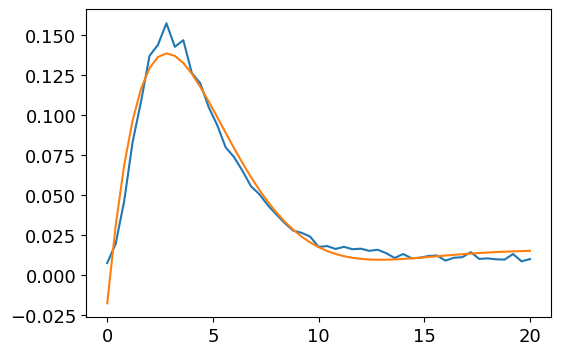



  freq: 0.04949205060980896 +/- 0.002756064742017431
 gamma: 0.30436423895230114 +/- 0.020506742148865467
   amp: 0.407830492252984 +/- 0.04392620111854007
 phase: -4.636488632179157 +/- 0.8499353658821296
offset: 0.015192519105306968 +/- 0.001899846379513362
pi_pulse time: 10.102632520562882 +/- 0.002756064742017431
J = 0.335: Angular freq (rad/µs): 0.31096772521374016


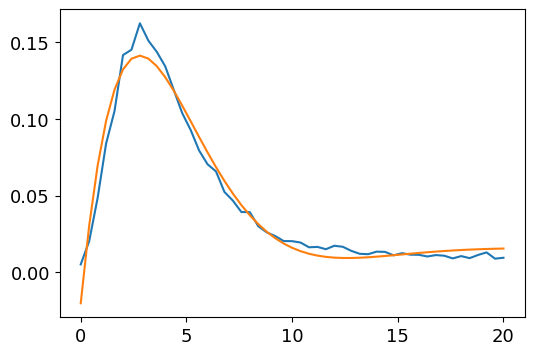



  freq: 0.0509419922414346 +/- 0.002816268390320751
 gamma: 0.30761235899210265 +/- 0.02135495820336301
   amp: 0.4115856966591664 +/- 0.04461372094565479
 phase: -4.973548448732499 +/- 0.8950922571349057
offset: 0.015400111392920024 +/- 0.0019560405754112534
pi_pulse time: 9.81508531567236 +/- 0.002816268390320751
J = 0.34: Angular freq (rad/µs): 0.3200779771698384


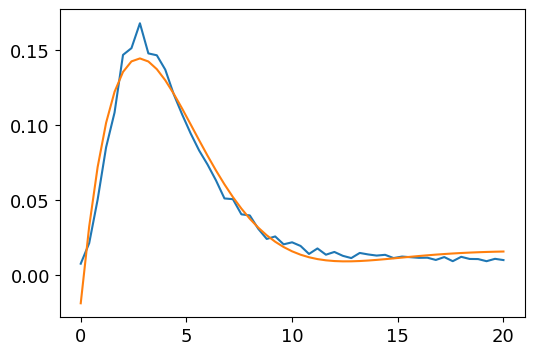



  freq: 0.05116884772041513 +/- 0.002775944659341341
 gamma: 0.30547506462537094 +/- 0.0213981179531881
   amp: 0.4153364066459455 +/- 0.04479674143777194
 phase: -4.756089014762972 +/- 0.9005324176292185
offset: 0.015472604029316208 +/- 0.002001719669890103
pi_pulse time: 9.771570443250614 +/- 0.002775944659341341
J = 0.34500000000000003: Angular freq (rad/µs): 0.321503352182222


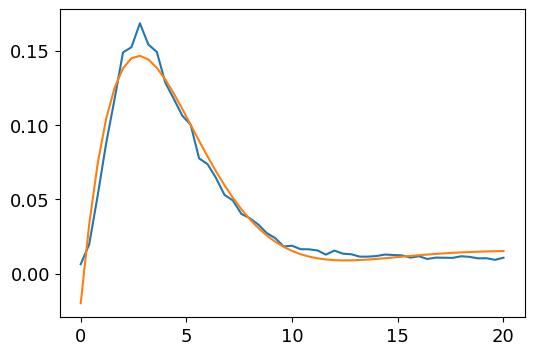



  freq: 0.05120140137943259 +/- 0.0027213500602460976
 gamma: 0.3120929508222852 +/- 0.02068750400921427
   amp: 0.430960084477176 +/- 0.044788650522738414
 phase: -4.6691341051606265 +/- 0.8419469491048419
offset: 0.01510895310090452 +/- 0.0019184823078812682
pi_pulse time: 9.765357715401285 +/- 0.0027213500602460976
J = 0.35000000000000003: Angular freq (rad/µs): 0.32170789285425544


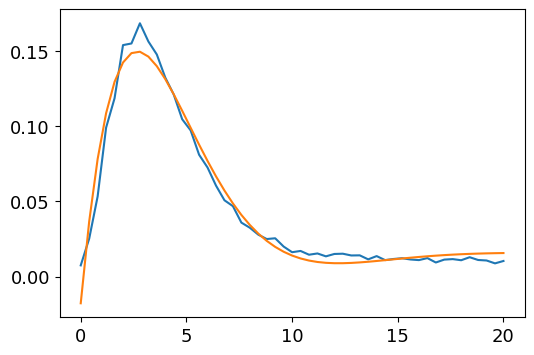



  freq: 0.05251176502583852 +/- 0.002562373754896374
 gamma: 0.3164712916299181 +/- 0.01999312553833109
   amp: 0.4334825051357389 +/- 0.042041518254910884
 phase: -4.390446906857673 +/- 0.8014923027927731
offset: 0.015505514091180195 +/- 0.0018067709410582319
pi_pulse time: 9.5216757569275 +/- 0.002562373754896374
J = 0.355: Angular freq (rad/µs): 0.32994115046441547


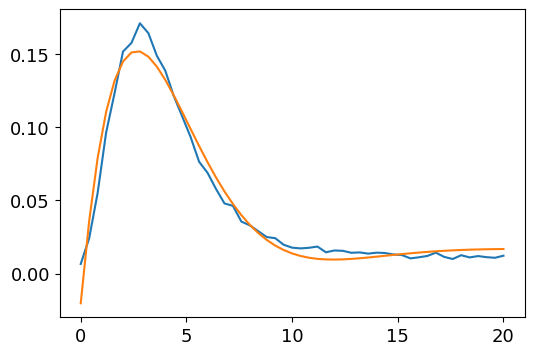



  freq: 0.05380477564663674 +/- 0.0027124138063800065
 gamma: 0.31992265086965643 +/- 0.021325249321464786
   amp: 0.4367120473163604 +/- 0.044025694462519416
 phase: -4.836607676666642 +/- 0.8641563897375528
offset: 0.01646218975112655 +/- 0.0019091683025126674
pi_pulse time: 9.292855401605122 +/- 0.0027124138063800065
J = 0.36: Angular freq (rad/µs): 0.338065375799042


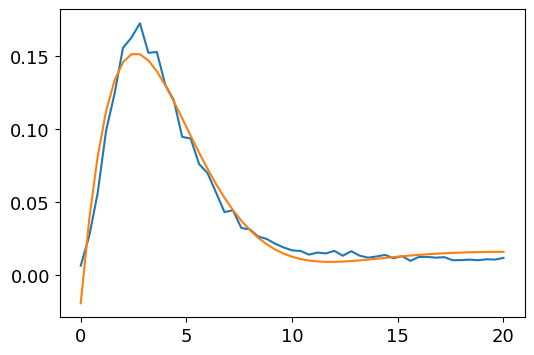



  freq: 0.05427407520896972 +/- 0.002813209944502383
 gamma: 0.3277737709855345 +/- 0.022066947180577532
   amp: 0.4426176632656988 +/- 0.045485387576514394
 phase: -4.541233644855858 +/- 0.8590457175899615
offset: 0.015682086116022877 +/- 0.0019002085159861546
pi_pulse time: 9.212501513381225 +/- 0.002813209944502383
J = 0.365: Angular freq (rad/µs): 0.3410140719137584


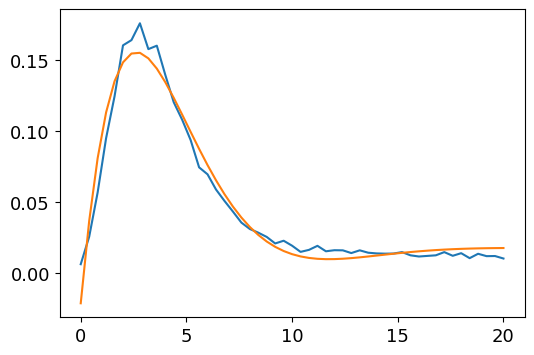



  freq: 0.05496235118756058 +/- 0.002763080937817129
 gamma: 0.32053009973501 +/- 0.022090054295729165
   amp: 0.43825310747652096 +/- 0.04471604969414614
 phase: -5.0351833919952576 +/- 0.9084938575517119
offset: 0.017338776423386142 +/- 0.001983722303079122
pi_pulse time: 9.097136297785658 +/- 0.002763080937817129
J = 0.37: Angular freq (rad/µs): 0.3453386374297251


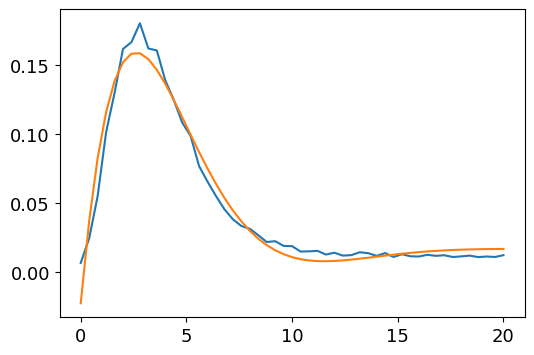



  freq: 0.056186547283397996 +/- 0.0026046342455269596
 gamma: 0.3183800001091829 +/- 0.021419049616402307
   amp: 0.4423582271682741 +/- 0.04271780101165836
 phase: -5.034625609121316 +/- 0.9018785674379699
offset: 0.016472791858668505 +/- 0.0019719722928056354
pi_pulse time: 8.898927308668066 +/- 0.0026046342455269596
J = 0.375: Angular freq (rad/µs): 0.35303048835219736


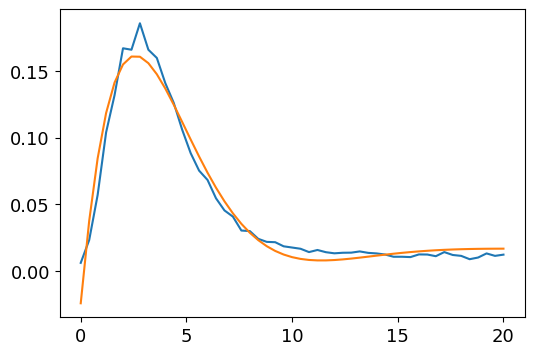



  freq: 0.056810332221776456 +/- 0.002746091064839235
 gamma: 0.32426129751809857 +/- 0.022466778582700235
   amp: 0.4534393457551415 +/- 0.04530544573011434
 phase: -5.120820629423104 +/- 0.9276474274015569
offset: 0.016337712684368285 +/- 0.0020475495650307653
pi_pulse time: 8.80121591347323 +/- 0.002746091064839235
J = 0.38: Angular freq (rad/µs): 0.35694984471185687


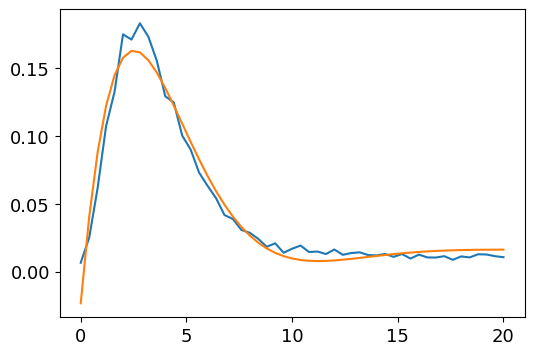



  freq: 0.05734356185530957 +/- 0.0028939981249906923
 gamma: 0.3343396656016768 +/- 0.023514356364254092
   amp: 0.4658193843130709 +/- 0.04791624753316399
 phase: -4.813299918133952 +/- 0.9244106264735185
offset: 0.015790944179873995 +/- 0.002065956804677366
pi_pulse time: 8.71937465729126 +/- 0.0028939981249906923
J = 0.385: Angular freq (rad/µs): 0.36030022531062483


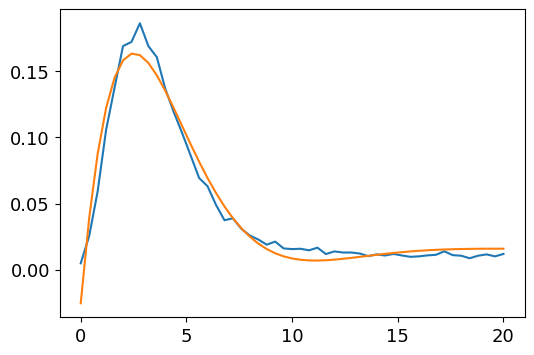



  freq: 0.058248442602571955 +/- 0.0028441421585262516
 gamma: 0.33334066460427014 +/- 0.023386600968559816
   amp: 0.4633617095795694 +/- 0.04670492023880099
 phase: -5.047203908113373 +/- 0.9375846118157336
offset: 0.015397869031378015 +/- 0.0020659204890888564
pi_pulse time: 8.583920490569863 +/- 0.0028441421585262516
J = 0.39: Angular freq (rad/µs): 0.3659857587265736


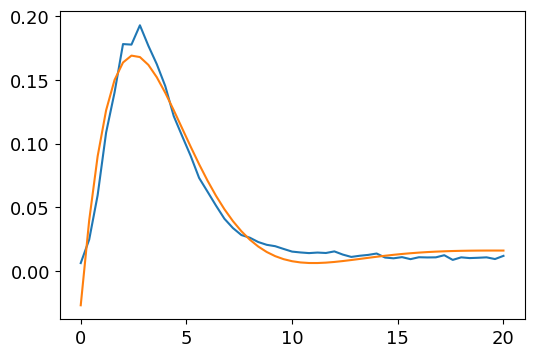



  freq: 0.05884038502953917 +/- 0.002853233599799995
 gamma: 0.3305087394260118 +/- 0.02379661034931452
   amp: 0.4740570674358925 +/- 0.04817132576814661
 phase: -5.129518291580011 +/- 0.9749438246786004
offset: 0.015525338199668946 +/- 0.002193325614663439
pi_pulse time: 8.497565060952422 +/- 0.002853233599799995
J = 0.395: Angular freq (rad/µs): 0.3697050426863902


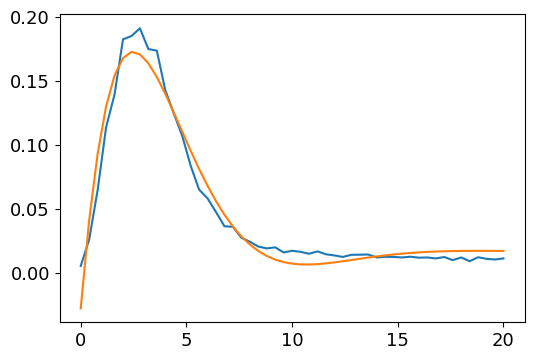



  freq: 0.06092384395963386 +/- 0.0028820667735387807
 gamma: 0.33432078867337345 +/- 0.0244650628046292
   amp: 0.47466386115149634 +/- 0.04780796867783518
 phase: -5.354577604293681 +/- 1.010722074557865
offset: 0.016371312671139882 +/- 0.002225253572809245
pi_pulse time: 8.206967379328258 +/- 0.0028820667735387807
J = 0.4: Angular freq (rad/µs): 0.38279580122407325


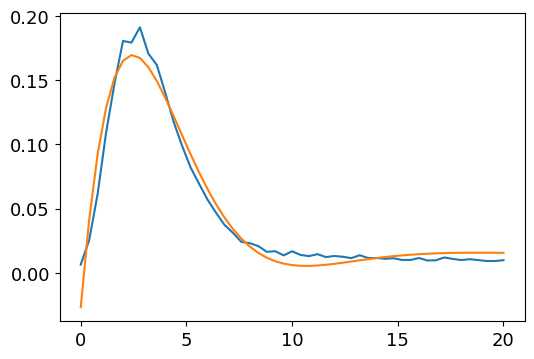



  freq: 0.060869521928244685 +/- 0.0028493631009098835
 gamma: 0.33725697465744137 +/- 0.024156551510914382
   amp: 0.4713155592962954 +/- 0.04676360385856744
 phase: -5.102616537651704 +/- 0.9790389041185071
offset: 0.014953216228946032 +/- 0.002138906869031607
pi_pulse time: 8.214291556116033 +/- 0.0028493631009098835
J = 0.405: Angular freq (rad/µs): 0.38245448583459263


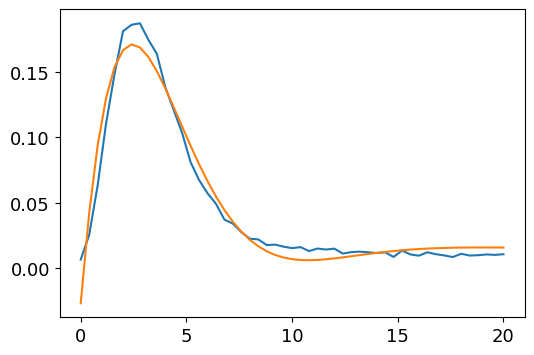



  freq: 0.06017954183466044 +/- 0.0029339588516898983
 gamma: 0.3406713087021569 +/- 0.024488313401705767
   amp: 0.4826212316062626 +/- 0.0490359223344107
 phase: -5.007950190883717 +/- 0.9671739902198029
offset: 0.01528780083031391 +/- 0.0021686085712122913
pi_pulse time: 8.308471363469648 +/- 0.0029339588516898983
J = 0.41000000000000003: Angular freq (rad/µs): 0.37811921304833773


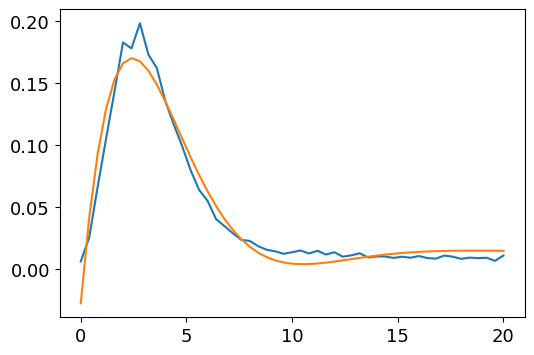



  freq: 0.06188458049826326 +/- 0.0029626466579223596
 gamma: 0.33695923557055635 +/- 0.025483910310054116
   amp: 0.4677187325781526 +/- 0.04814154455726095
 phase: -5.116938759548811 +/- 1.0462817279647194
offset: 0.014292175285178782 +/- 0.002251450096192259
pi_pulse time: 8.079557071798073 +/- 0.0029626466579223596
J = 0.41500000000000004: Angular freq (rad/µs): 0.3888322869276601


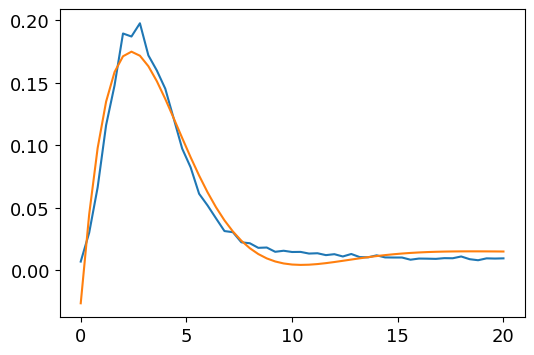



  freq: 0.062171368246257075 +/- 0.0029470347353000212
 gamma: 0.3425903393934085 +/- 0.025306377042581398
   amp: 0.48434427589976436 +/- 0.04905064205256015
 phase: -4.842220396795975 +/- 1.009856706024118
offset: 0.014625379771892435 +/- 0.0022367506987823475
pi_pulse time: 8.042287215226306 +/- 0.0029470347353000212
J = 0.42: Angular freq (rad/µs): 0.39063422749213395


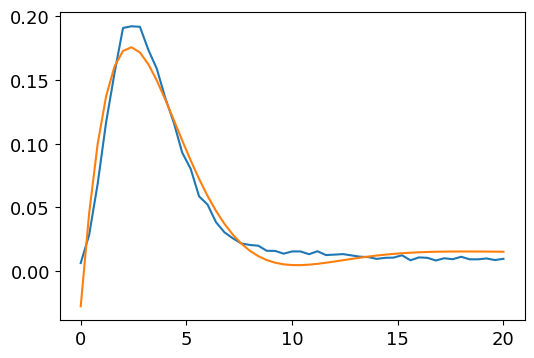



  freq: 0.06339993351282332 +/- 0.0029929041593389715
 gamma: 0.3509732176317592 +/- 0.025595359567172078
   amp: 0.4885251919516329 +/- 0.048935728735271626
 phase: -4.968881812190587 +/- 0.9954987836924072
offset: 0.014834333380481058 +/- 0.002186070618460789
pi_pulse time: 7.88644360169352 +/- 0.0029929041593389715
J = 0.425: Angular freq (rad/µs): 0.3983535307239341


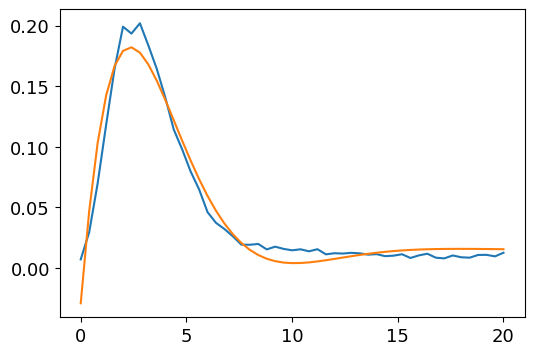



  freq: 0.06430685908455072 +/- 0.003045287172688279
 gamma: 0.3493277987101385 +/- 0.026380646835188076
   amp: 0.5011314045311538 +/- 0.05107066499054529
 phase: -5.0606080220120795 +/- 1.0457585316425382
offset: 0.01496210785172385 +/- 0.002343749097243947
pi_pulse time: 7.775220359349218 +/- 0.003045287172688279
J = 0.43: Angular freq (rad/µs): 0.4040519121509172


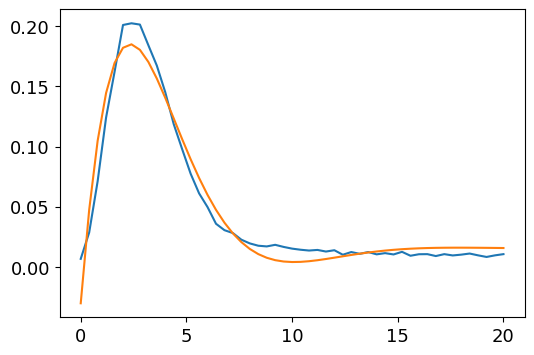



  freq: 0.0644838401750342 +/- 0.003031914029345223
 gamma: 0.35069798815406694 +/- 0.02621575921127386
   amp: 0.5096441755294009 +/- 0.051464347027137126
 phase: -5.117693057135908 +/- 1.0350389094788737
offset: 0.015218430213039468 +/- 0.002352893600356859
pi_pulse time: 7.75388064114677 +/- 0.003031914029345223
J = 0.435: Angular freq (rad/µs): 0.4051639171382916


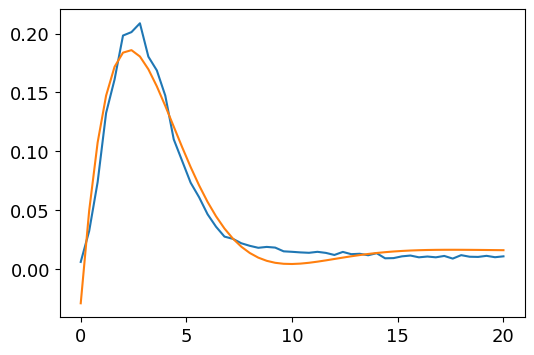



  freq: 0.06559043125361351 +/- 0.0030607380283565436
 gamma: 0.35560877374404065 +/- 0.026614682276647685
   amp: 0.509625777414121 +/- 0.0512359154870622
 phase: -5.028227743070202 +/- 1.036785875280901
offset: 0.01573525223303619 +/- 0.002331635366022317
pi_pulse time: 7.623063157897044 +/- 0.0030607380283565436
J = 0.44: Angular freq (rad/µs): 0.4121168339442771


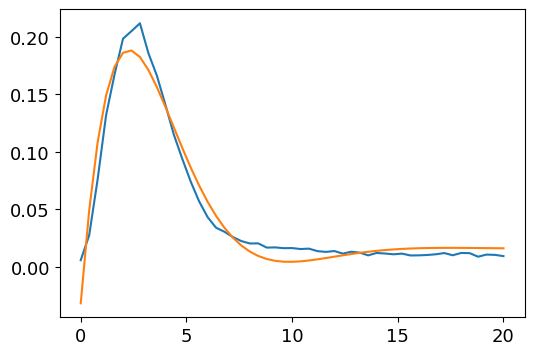



  freq: 0.06599714469773381 +/- 0.0031306304396065275
 gamma: 0.358637922178844 +/- 0.02706101858806127
   amp: 0.5190140770074424 +/- 0.052744970856654666
 phase: -5.244629417365943 +/- 1.0464528706451226
offset: 0.015764599578236196 +/- 0.0023819677128753135
pi_pulse time: 7.576085333539723 +/- 0.0031306304396065275
J = 0.445: Angular freq (rad/µs): 0.4146722898806062


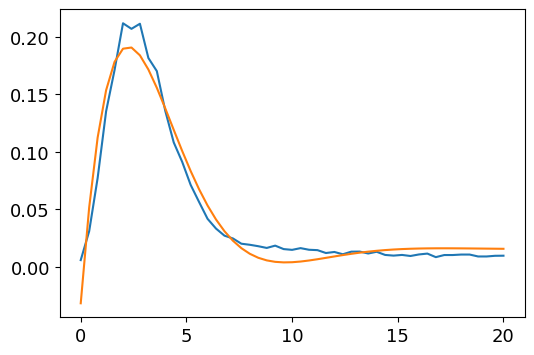



  freq: 0.06710797174084099 +/- 0.0032508051504294977
 gamma: 0.36597069953443734 +/- 0.028160206227979358
   amp: 0.529207714057015 +/- 0.054827844491120964
 phase: -5.100851426248798 +/- 1.061652866784793
offset: 0.015352690536590961 +/- 0.002435295915736744
pi_pulse time: 7.450679658907153 +/- 0.0032508051504294977
J = 0.45: Angular freq (rad/µs): 0.42165182203667495


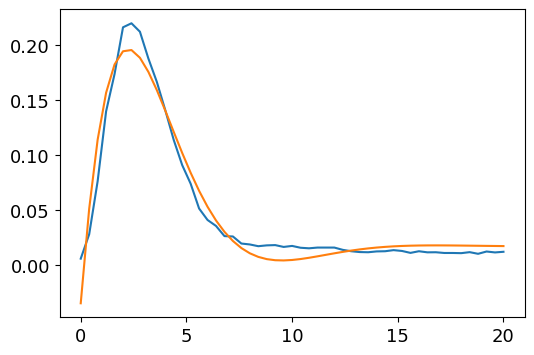



  freq: 0.0687928296444526 +/- 0.0032274816856688406
 gamma: 0.3632330490983885 +/- 0.028292151634069854
   amp: 0.5288164522034091 +/- 0.05402650292011524
 phase: -5.612400710793876 +/- 1.104873985527691
offset: 0.016987965698083685 +/- 0.0025101576358177616
pi_pulse time: 7.268199354266852 +/- 0.0032274816856688406
J = 0.455: Angular freq (rad/µs): 0.4322380964613329


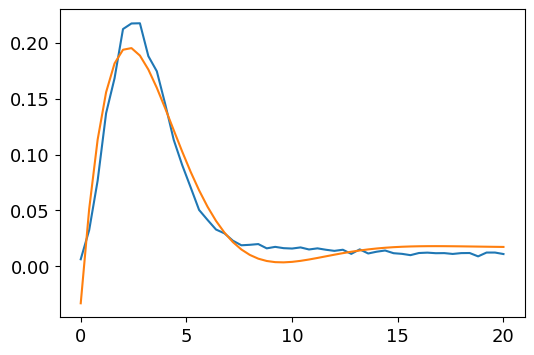



  freq: -0.06900704233978566 +/- 0.0031796315848631887
 gamma: 0.3565369726980064 +/- 0.028307779842715756
   amp: -0.5175404878708303 +/- 0.05290826134287082
 phase: 5.550869408788167 +/- 1.1425203944420863
offset: 0.017036438138635954 +/- 0.0025521440192022133
pi_pulse time: -7.245637300871936 +/- 0.0031796315848631887
J = 0.46: Angular freq (rad/µs): 0.4335840345212609


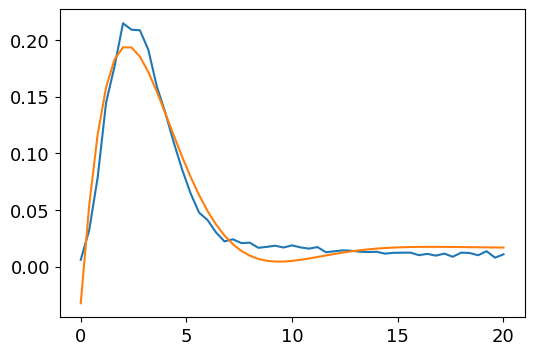



  freq: -0.06957032100285186 +/- 0.0033145207055435932
 gamma: 0.3727041332194781 +/- 0.02899721304485069
   amp: -0.5288990278277023 +/- 0.05442476778433681
 phase: 5.3080265017488015 +/- 1.0876361579421803
offset: 0.016675932441962152 +/- 0.002446415765561695
pi_pulse time: -7.186972731942745 +/- 0.0033145207055435932
J = 0.465: Angular freq (rad/µs): 0.4371232187408862


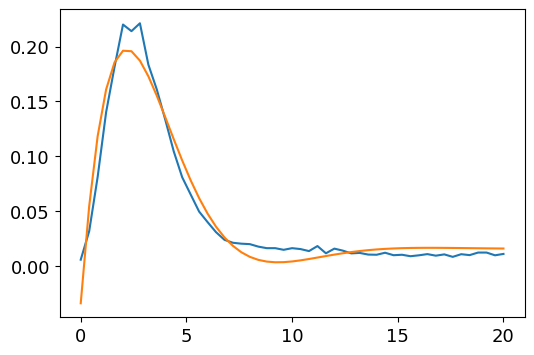



  freq: -0.0698808383698615 +/- 0.00346382505478948
 gamma: 0.37544947637509685 +/- 0.03027173354170821
   amp: -0.5399082784946678 +/- 0.05767924078056295
 phase: 5.276608047905224 +/- 1.1238077495352172
offset: 0.01589019034433629 +/- 0.0025715381434011767
pi_pulse time: -7.155037227138392 +/- 0.00346382505478948
J = 0.47000000000000003: Angular freq (rad/µs): 0.4390742568989053


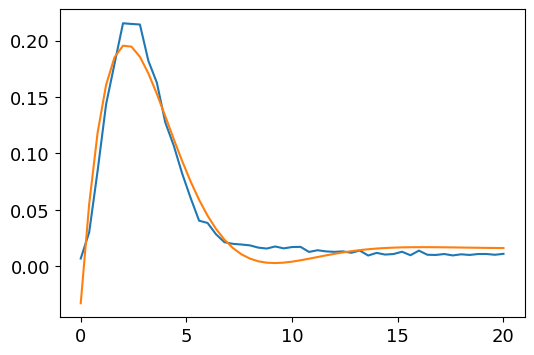



  freq: -0.07137807225124171 +/- 0.0033027936673494236
 gamma: 0.37387020469352245 +/- 0.029355700570577323
   amp: -0.5257963550181484 +/- 0.05345085741963295
 phase: 5.316613819784988 +/- 1.113591436855034
offset: 0.016109339894584757 +/- 0.002466701454386554
pi_pulse time: -7.004952420682696 +/- 0.0033027936673494236
J = 0.47500000000000003: Angular freq (rad/µs): 0.4484816548238048


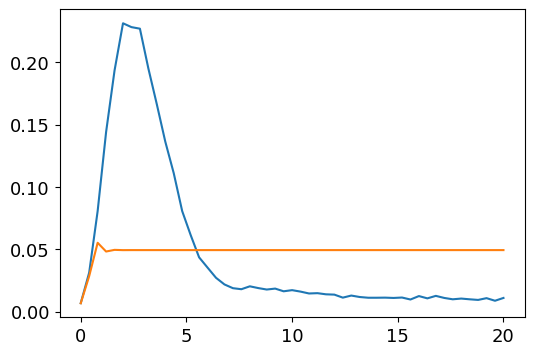



  freq: 1.2236947228501236 +/- 486.41001186028393
 gamma: 5.198162370485882 +/- 173.43208007656503
   amp: -3.1687535776443796 +/- 58599.80438750423
 phase: 0.7713140932861953 +/- 14260.331789007912
offset: 0.04929625172733726 +/- 0.00998230921507725
pi_pulse time: 0.4085986403826629 +/- 486.41001186028393
J = 0.48: Angular freq (rad/µs): 7.688700703085092


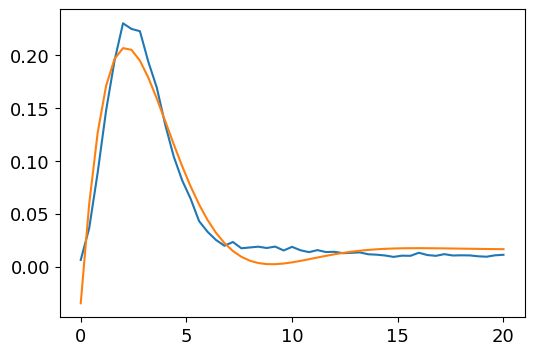



  freq: -0.07247284900242455 +/- 0.0033641165434407745
 gamma: 0.37704283838281066 +/- 0.03007078414653912
   amp: -0.5545257495668476 +/- 0.056834347171951016
 phase: 5.288620035102898 +/- 1.1353207447175475
offset: 0.016364718429366862 +/- 0.0026326495974862214
pi_pulse time: -6.899135426334249 +/- 0.0033641165434407745
J = 0.485: Angular freq (rad/µs): 0.4553603400214787


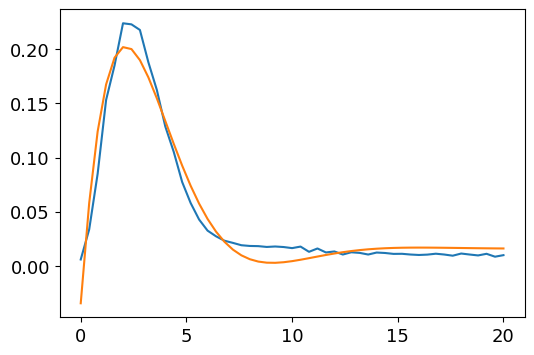



  freq: -0.0720682133063516 +/- 0.003480217287712041
 gamma: 0.382109249253523 +/- 0.03074209227835944
   amp: -0.5497656176783295 +/- 0.057752389025062155
 phase: 5.270499752191755 +/- 1.1296774745865041
offset: 0.015888456960558756 +/- 0.0025924451347089125
pi_pulse time: -6.937871456235108 +/- 0.003480217287712041
J = 0.49: Angular freq (rad/µs): 0.45281793896115274


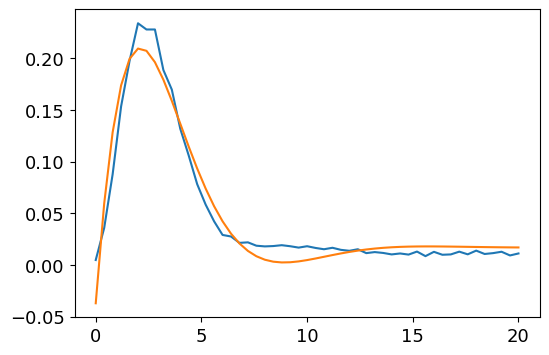



  freq: -0.0735897762361848 +/- 0.0034722311228381065
 gamma: 0.38146086163745285 +/- 0.030968921388767712
   amp: -0.5599688347947829 +/- 0.05825639492109731
 phase: 5.5237523875458665 +/- 1.1598681435550258
offset: 0.016902835954077308 +/- 0.002692643673069589
pi_pulse time: -6.794422072914867 +/- 0.0034722311228381065
J = 0.495: Angular freq (rad/µs): 0.4623782008058298
J = 0.0: omega = 0.7331002337972038 rad/µs
J = 0.005: omega = 0.01040140691976512 rad/µs
J = 0.01: omega = 0.0107557064078393 rad/µs
J = 0.015: omega = 0.014382636696552108 rad/µs
J = 0.02: omega = 1.7999636266179893 rad/µs
J = 0.025: omega = 0.0032330623735901632 rad/µs
J = 0.03: omega = nan rad/µs
J = 0.035: omega = 0.004848396405363542 rad/µs
J = 0.04: omega = 0.008848207988814246 rad/µs
J = 0.045: omega = 0.005738228508719588 rad/µs
J = 0.05: omega = 0.0016884110550560078 rad/µs
J = 0.055: omega = 0.0020350180340288843 rad/µs
J = 0.06: omega = nan rad/µs
J = 0.065: omega = nan rad/µs
J = 0.07: omega = nan rad/µ

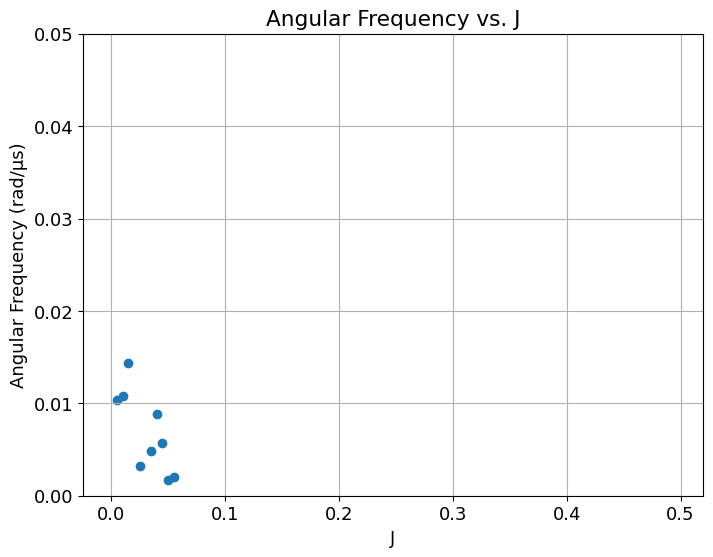

C:\Users\quantum1\AppData\Local\Temp\ipykernel_7364\909373872.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, np.sqrt(expr), 0.0)


Fitted J0 = 0.16729405543387482


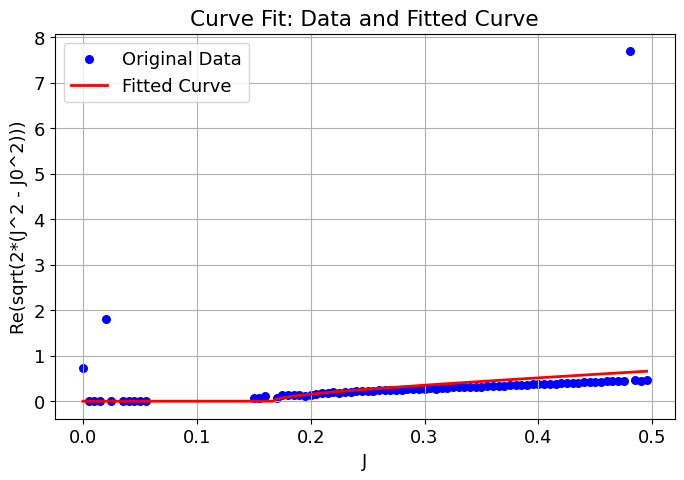

In [23]:
# Now call the function to process each J value and extract the angular frequency
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]

plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.ylim(0, 0.05)
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
mask_rb = ~np.isnan(omegas)

# Perform the curve fitting and plotting
popt, pcov = curve_fit_and_plot(
    np.array(J_vals)[mask_rb], np.array(omegas)[mask_rb], initial_guess_J0
)

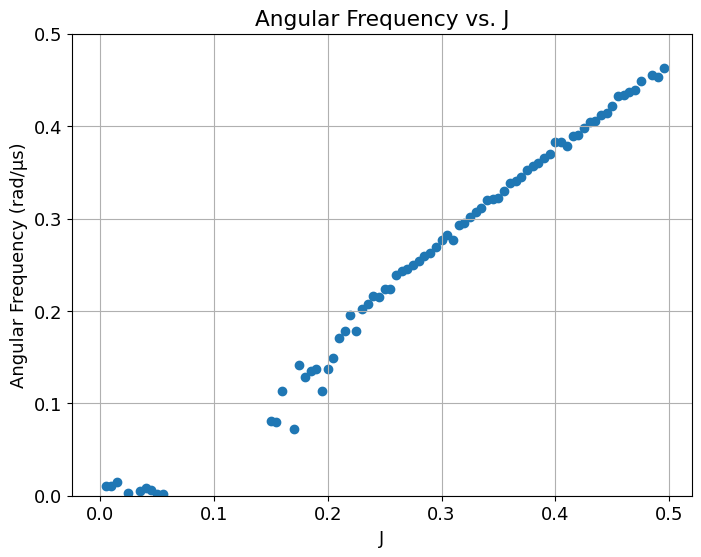

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.ylim(0, 0.5)
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

<Figure size 960x720 with 0 Axes>

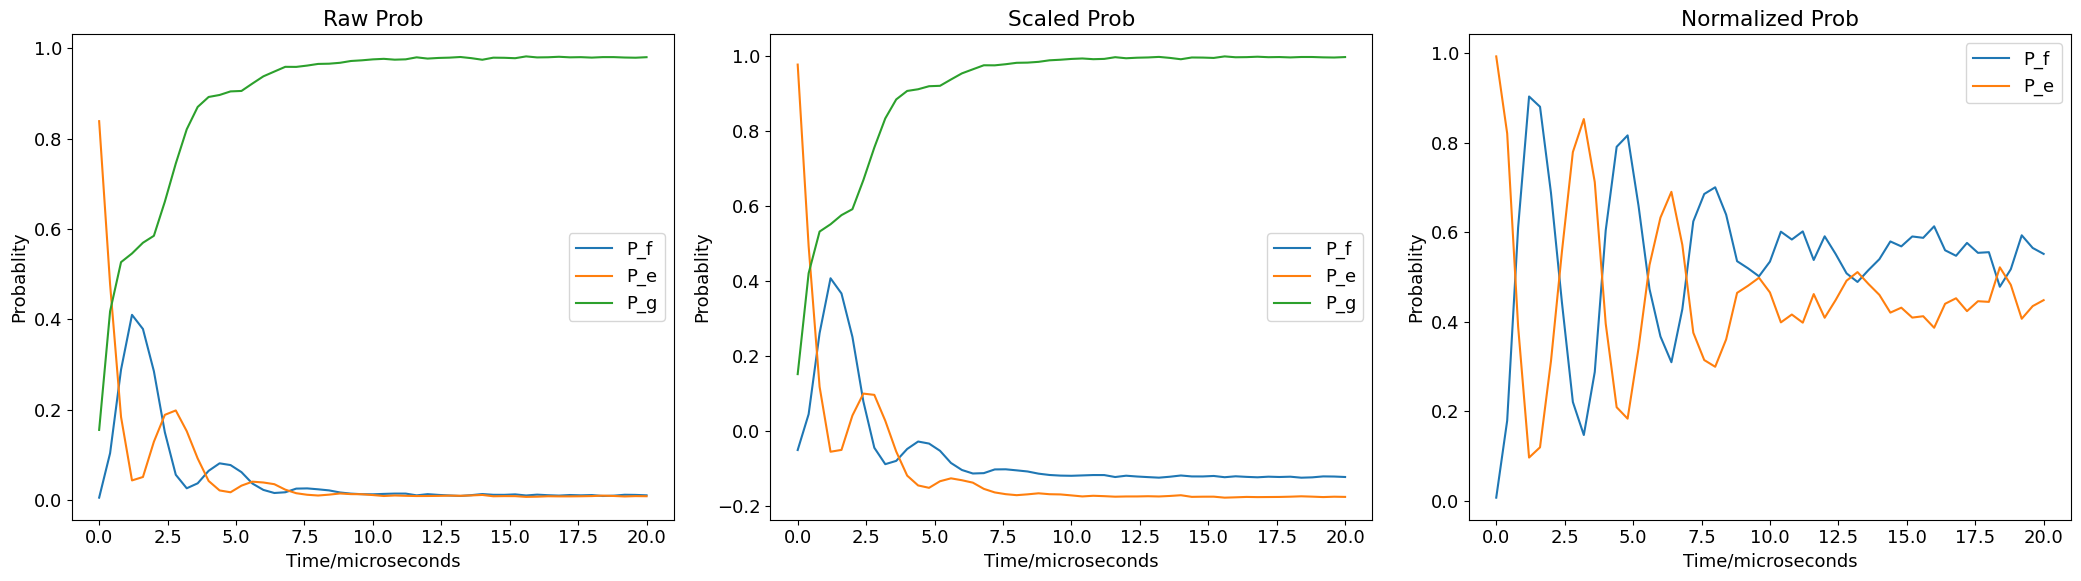

In [ ]:
scale_matrix = np.array(
    [
        [1.01788813, -0.0081921, -0.00969603],
        [-0.19047774, 1.201006, -0.01052826],
        [-0.13825531, -0.04327379, 1.18152911],
    ]
)
J = 1
measured_pop = np.array(
    [
        probability_dataframes[J]["P_g"],
        probability_dataframes[J]["P_e"],
        probability_dataframes[J]["P_f"],
    ]
)
scaled_p = np.matmul(scale_matrix, measured_pop)
scaled_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_g": scaled_p[0],
        "P_e": scaled_p[1],
        "P_f": scaled_p[2],
    }
)
normalization_val = probability_dataframes[J]["P_f"] + probability_dataframes[J]["P_e"]
normalized_df = pd.DataFrame(
    {
        "time": probability_dataframes[J]["time"],
        "P_f": probability_dataframes[J]["P_f"] / normalization_val,
        "P_e": probability_dataframes[J]["P_e"] / normalization_val,
        "P_g": probability_dataframes[J]["P_g"] / normalization_val,
    }
)
keys = ["P_f", "P_e", "P_g"]
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for key in keys:
    sns.lineplot(data=probability_dataframes[J], x="time", y=key, ax=axes[0], label=key)
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[1], label=key)
    if "P_g" != key:
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[2], label=key)
axes[1].set_xlabel("Time/microseconds")
axes[1].set_ylabel("Probablity")
axes[1].set_title("Scaled Prob")
axes[1].legend()
axes[0].set_xlabel("Time/microseconds")
axes[0].set_ylabel("Probablity")
axes[0].set_title("Raw Prob")
axes[0].legend()
axes[2].set_xlabel("Time/microseconds")
axes[2].set_ylabel("Probablity")
axes[2].set_title("Normalized Prob")
axes[2].legend()
# Adjust layout for better spacing
plt.tight_layout()

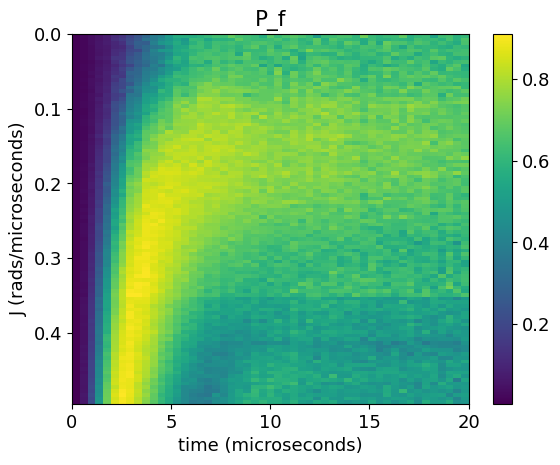

In [16]:
num_steps = 51
sweep_time = 20000
J_start = 0  # J_list[0]
J_stop = 0.495  # J_list[-1]
J_steps = 100  # len(J_list)
J_vals = np.linspace(J_start, J_stop, J_steps)
p_f = np.zeros((J_steps, num_steps))
for i in range(J_steps):
    p_f[i] = probability_dataframes[J_vals[i]]["P_f"] / (
        probability_dataframes[J_vals[i]]["P_f"]
        + probability_dataframes[J_vals[i]]["P_e"]
    )
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("time (microseconds)")
plt.title("P_f")
plt.show()

In [13]:
J_stop

1.0